In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from experiment_analysis.experiment_data_utils import get_full_runs_df
from lib.config import AppConfig
from experiment_analysis.experiment_data_utils import clean_experiment_data
import matplotlib.pyplot as plt
import seaborn as sns

config = AppConfig()
runs = get_full_runs_df(config.optimization_experiment_results_path)

In [36]:
runs.shape

(16023, 105)

In [37]:
runs["params.model_type"].value_counts()

params.model_type
random_forest    1600
elasticnet       1600
ridge            1600
lasso            1600
xgboost          1600
pls              1600
extra_trees      1600
svr              1600
gbr              1600
ngboost          1543
Name: count, dtype: int64

In [38]:
filtered_runs = clean_experiment_data(runs)

filtered_runs = filtered_runs[filtered_runs['metrics.rmse_cv'] <= 50]

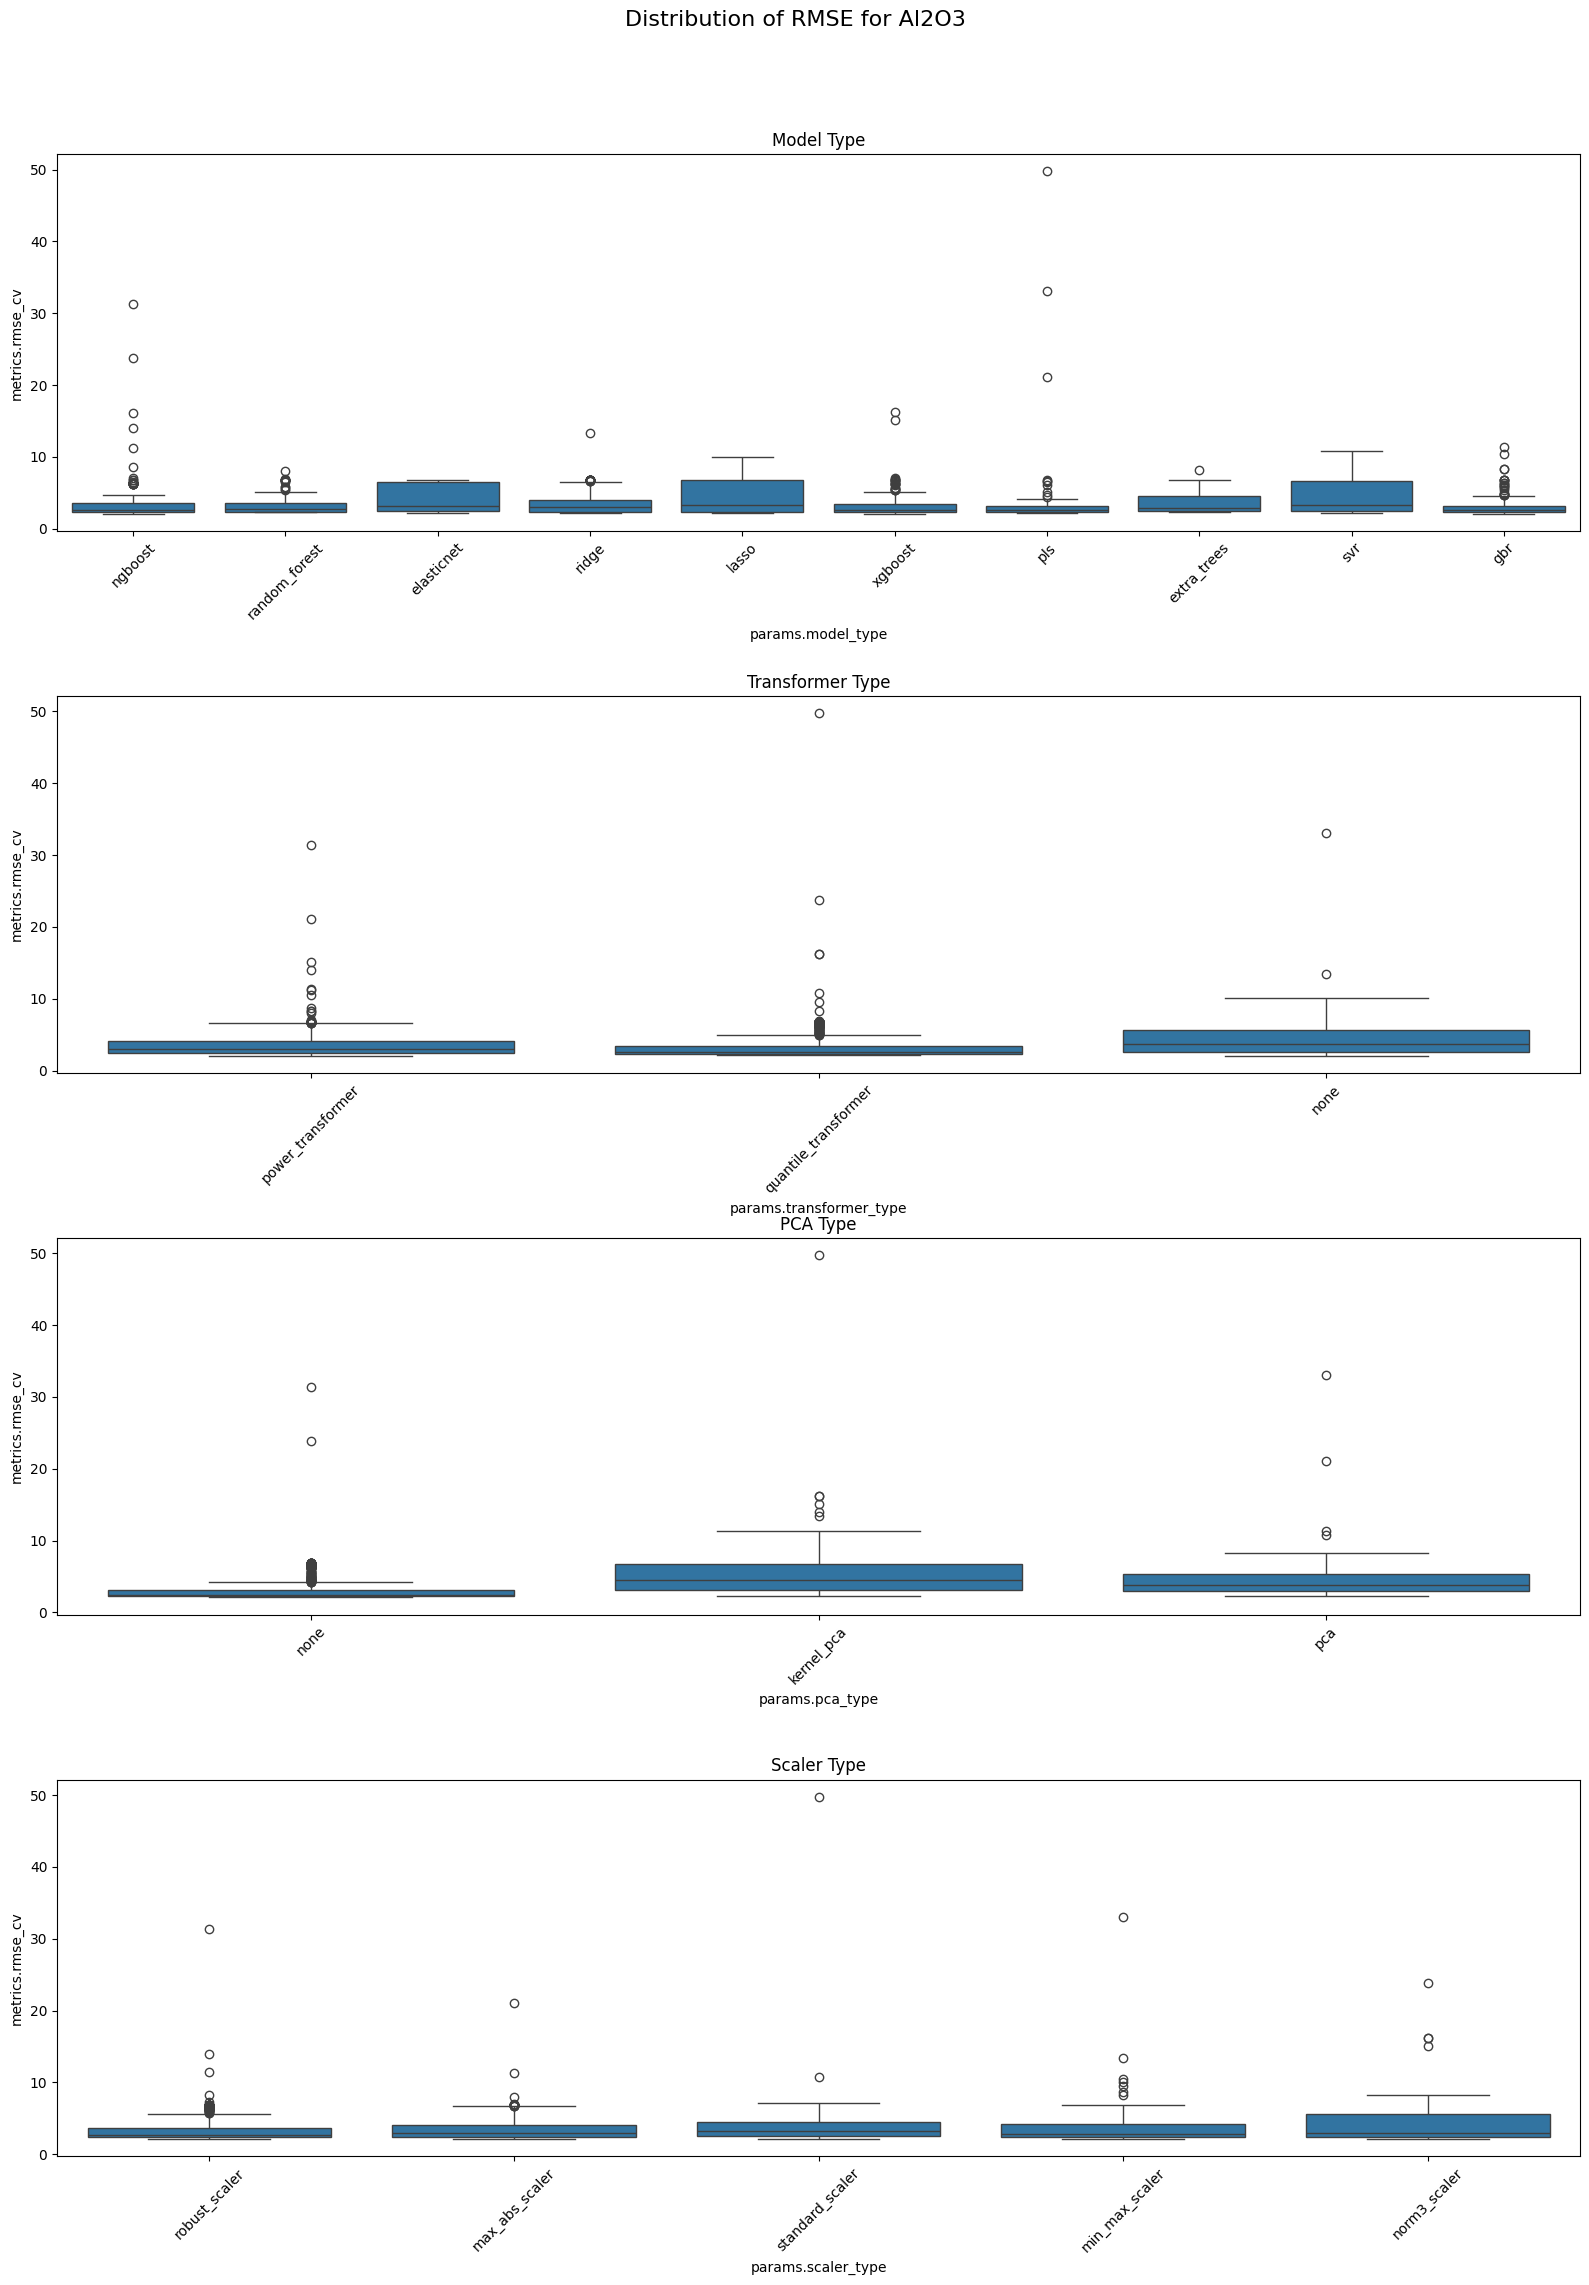

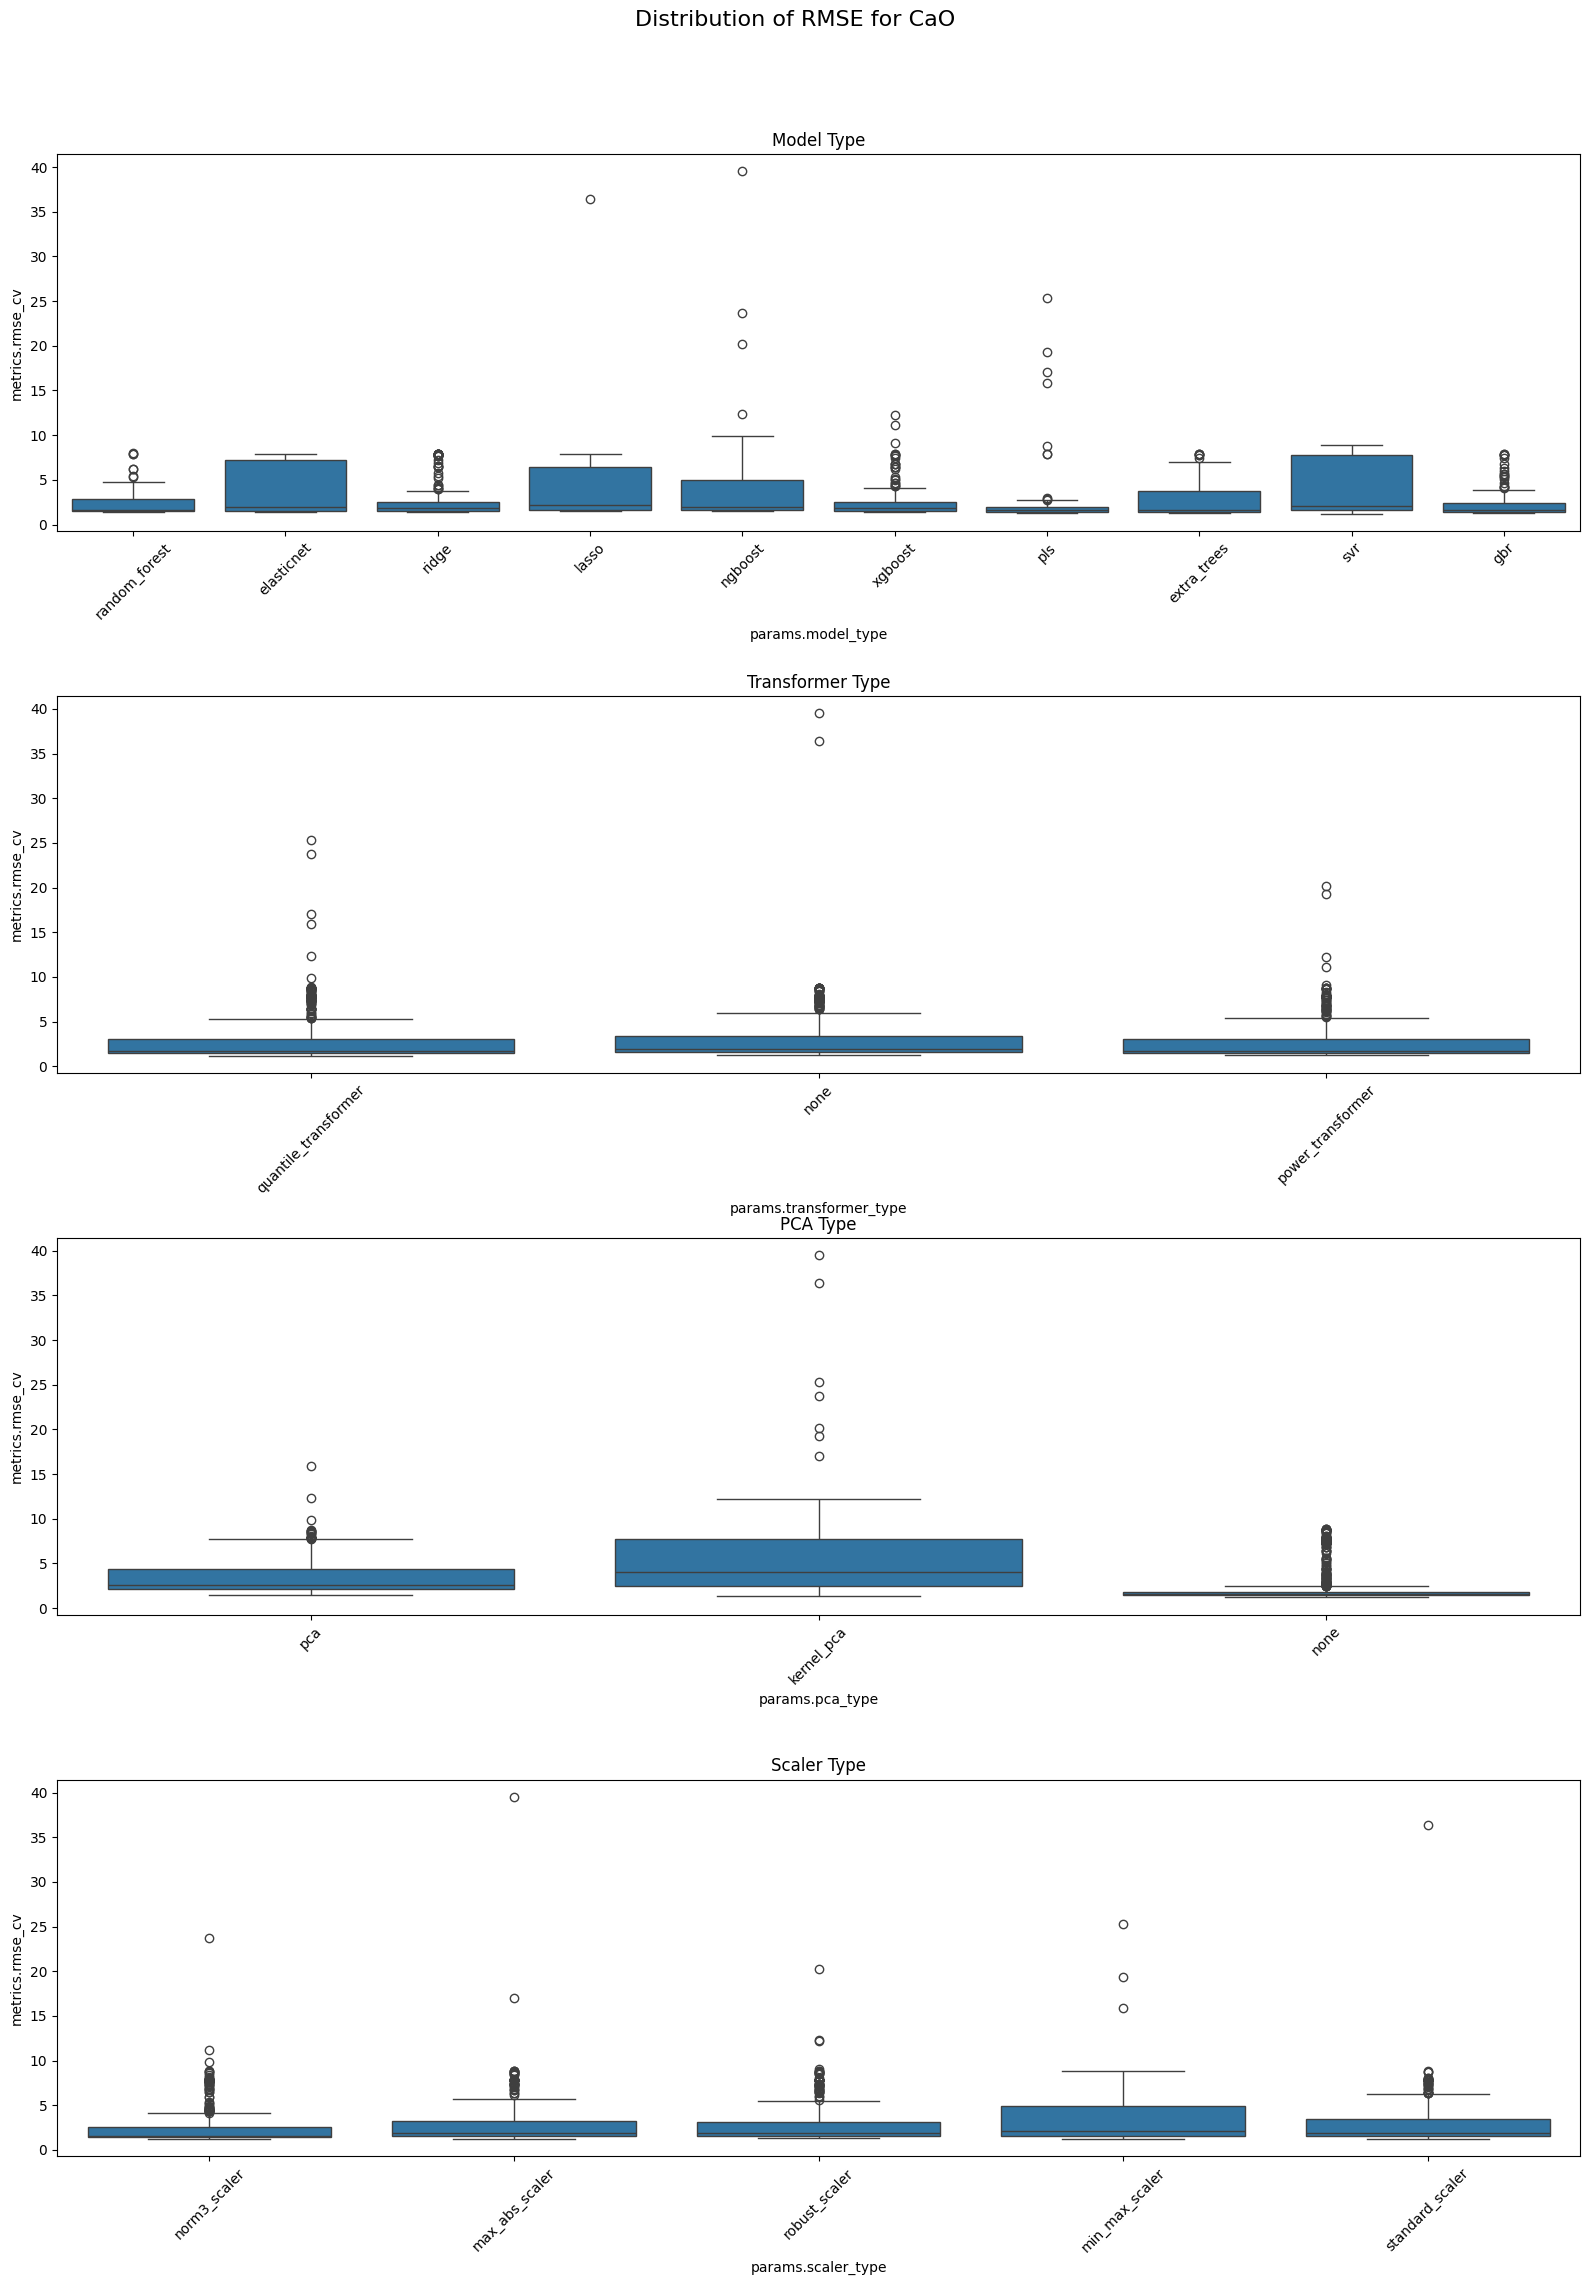

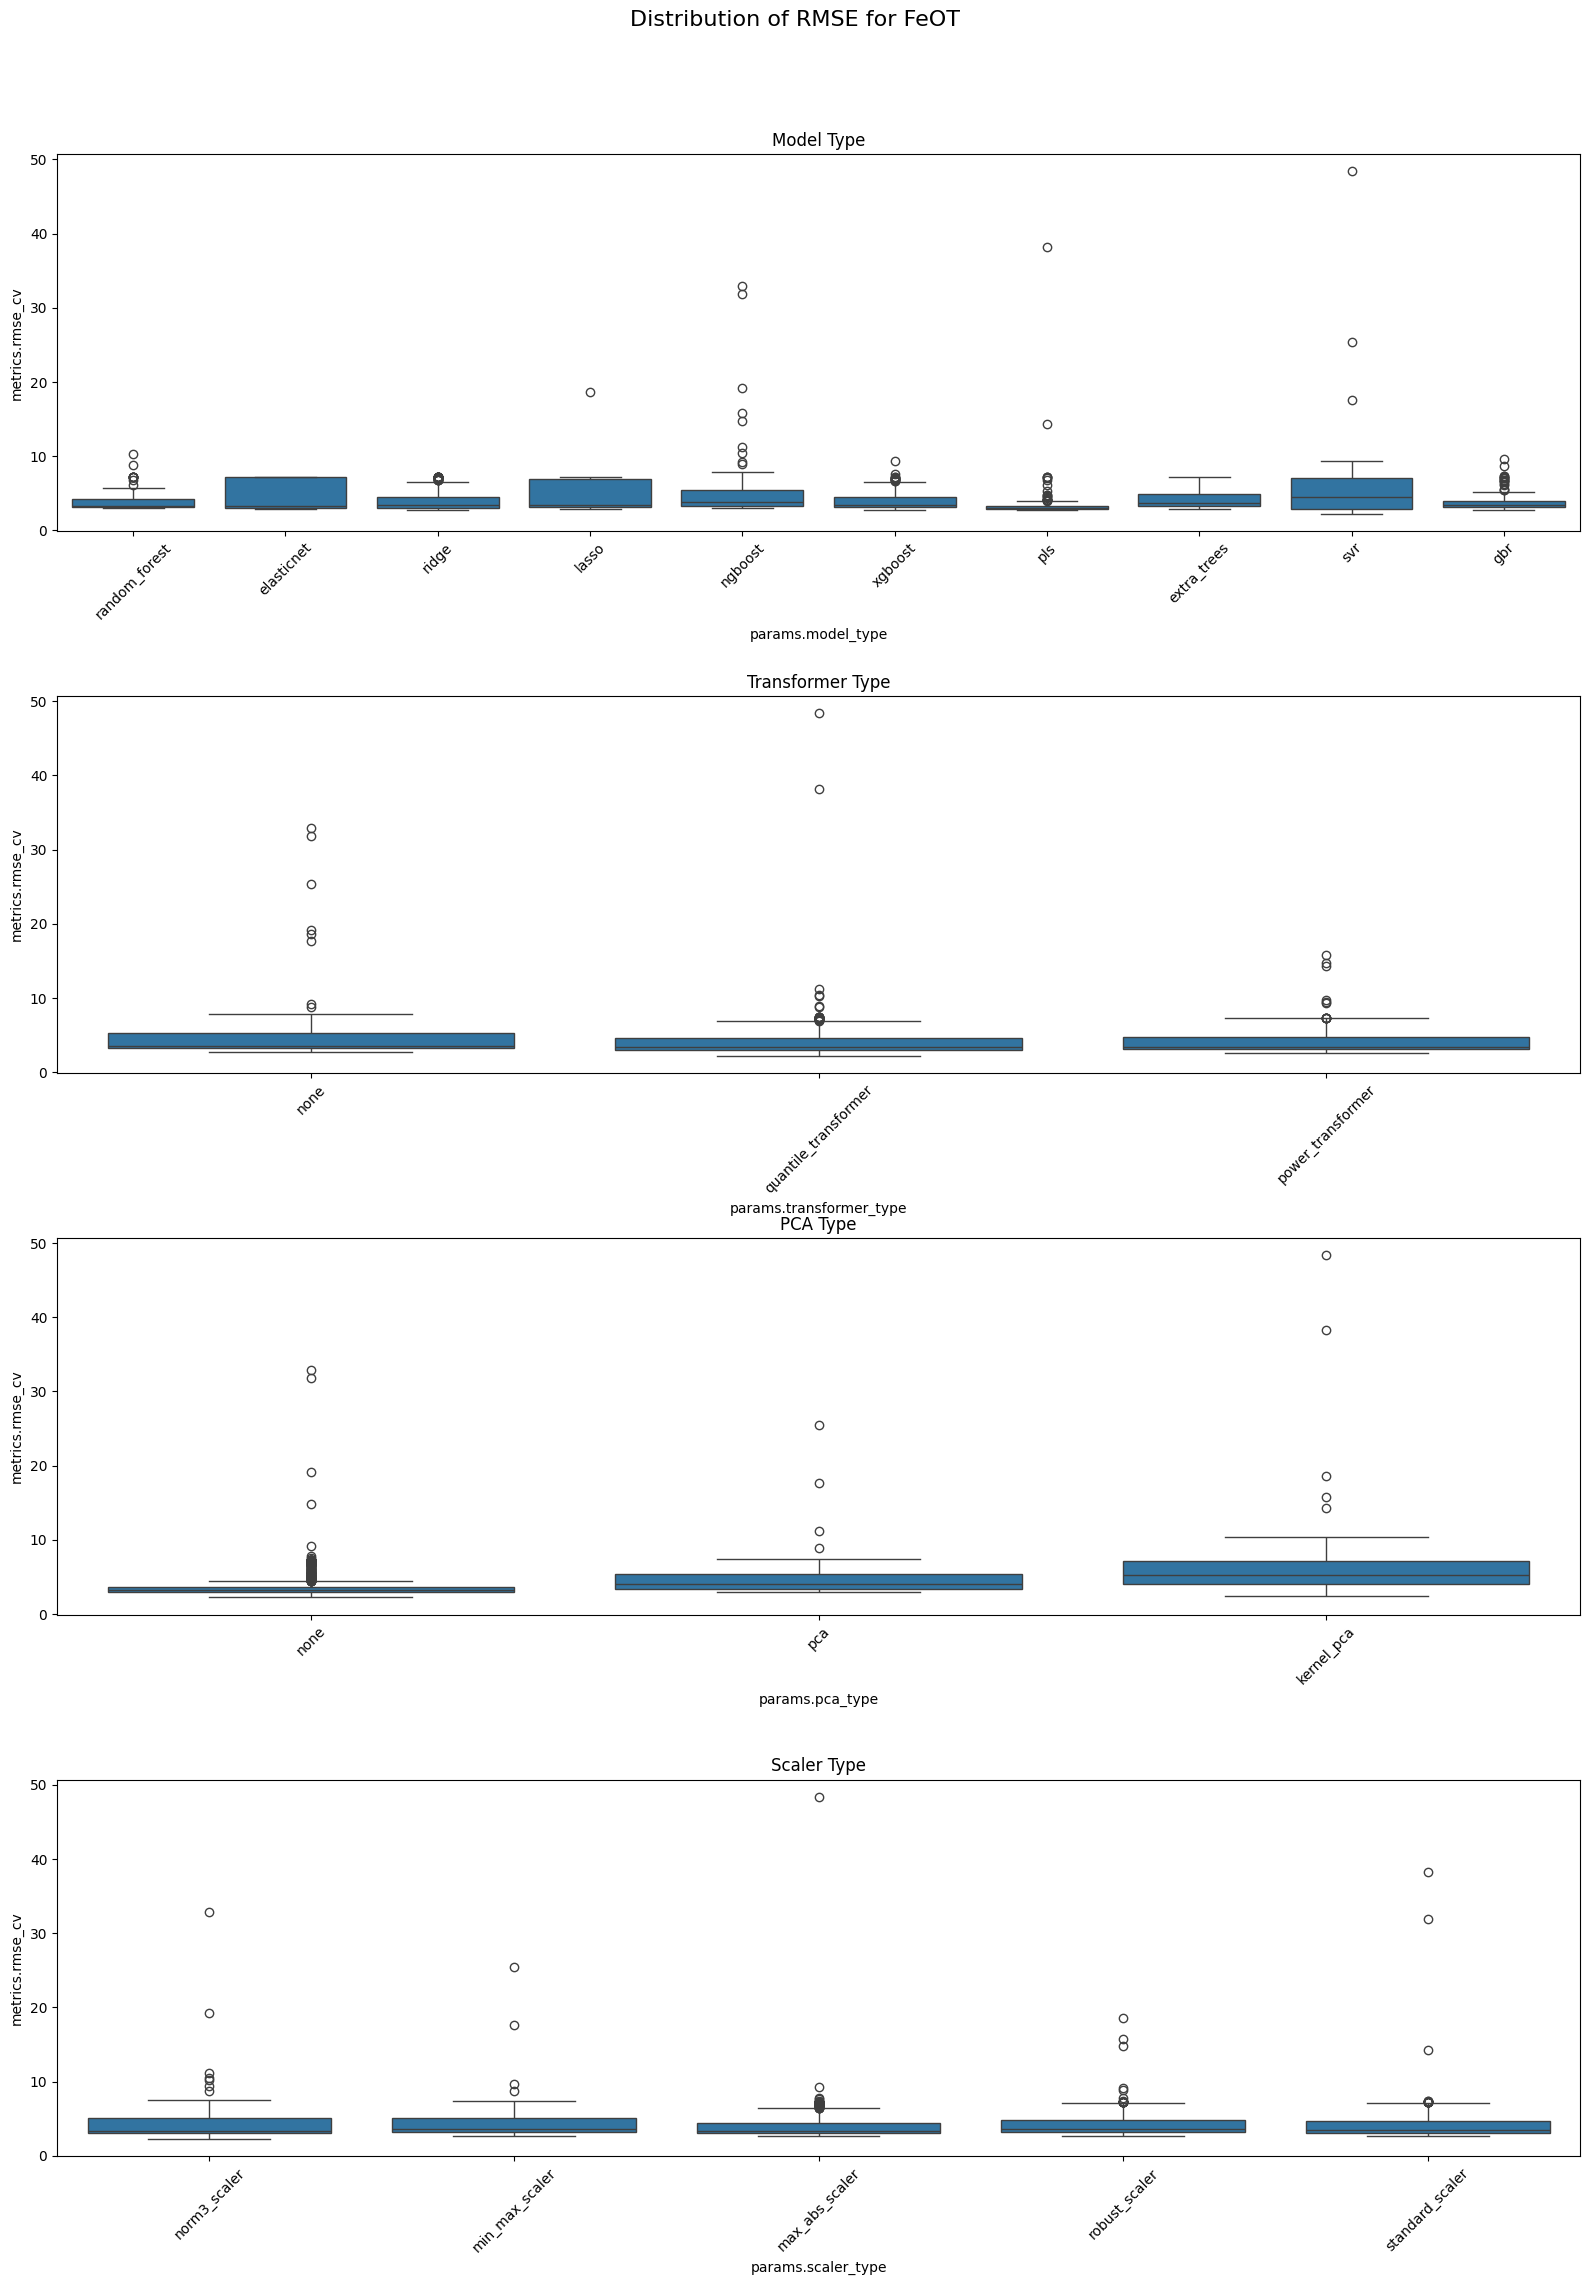

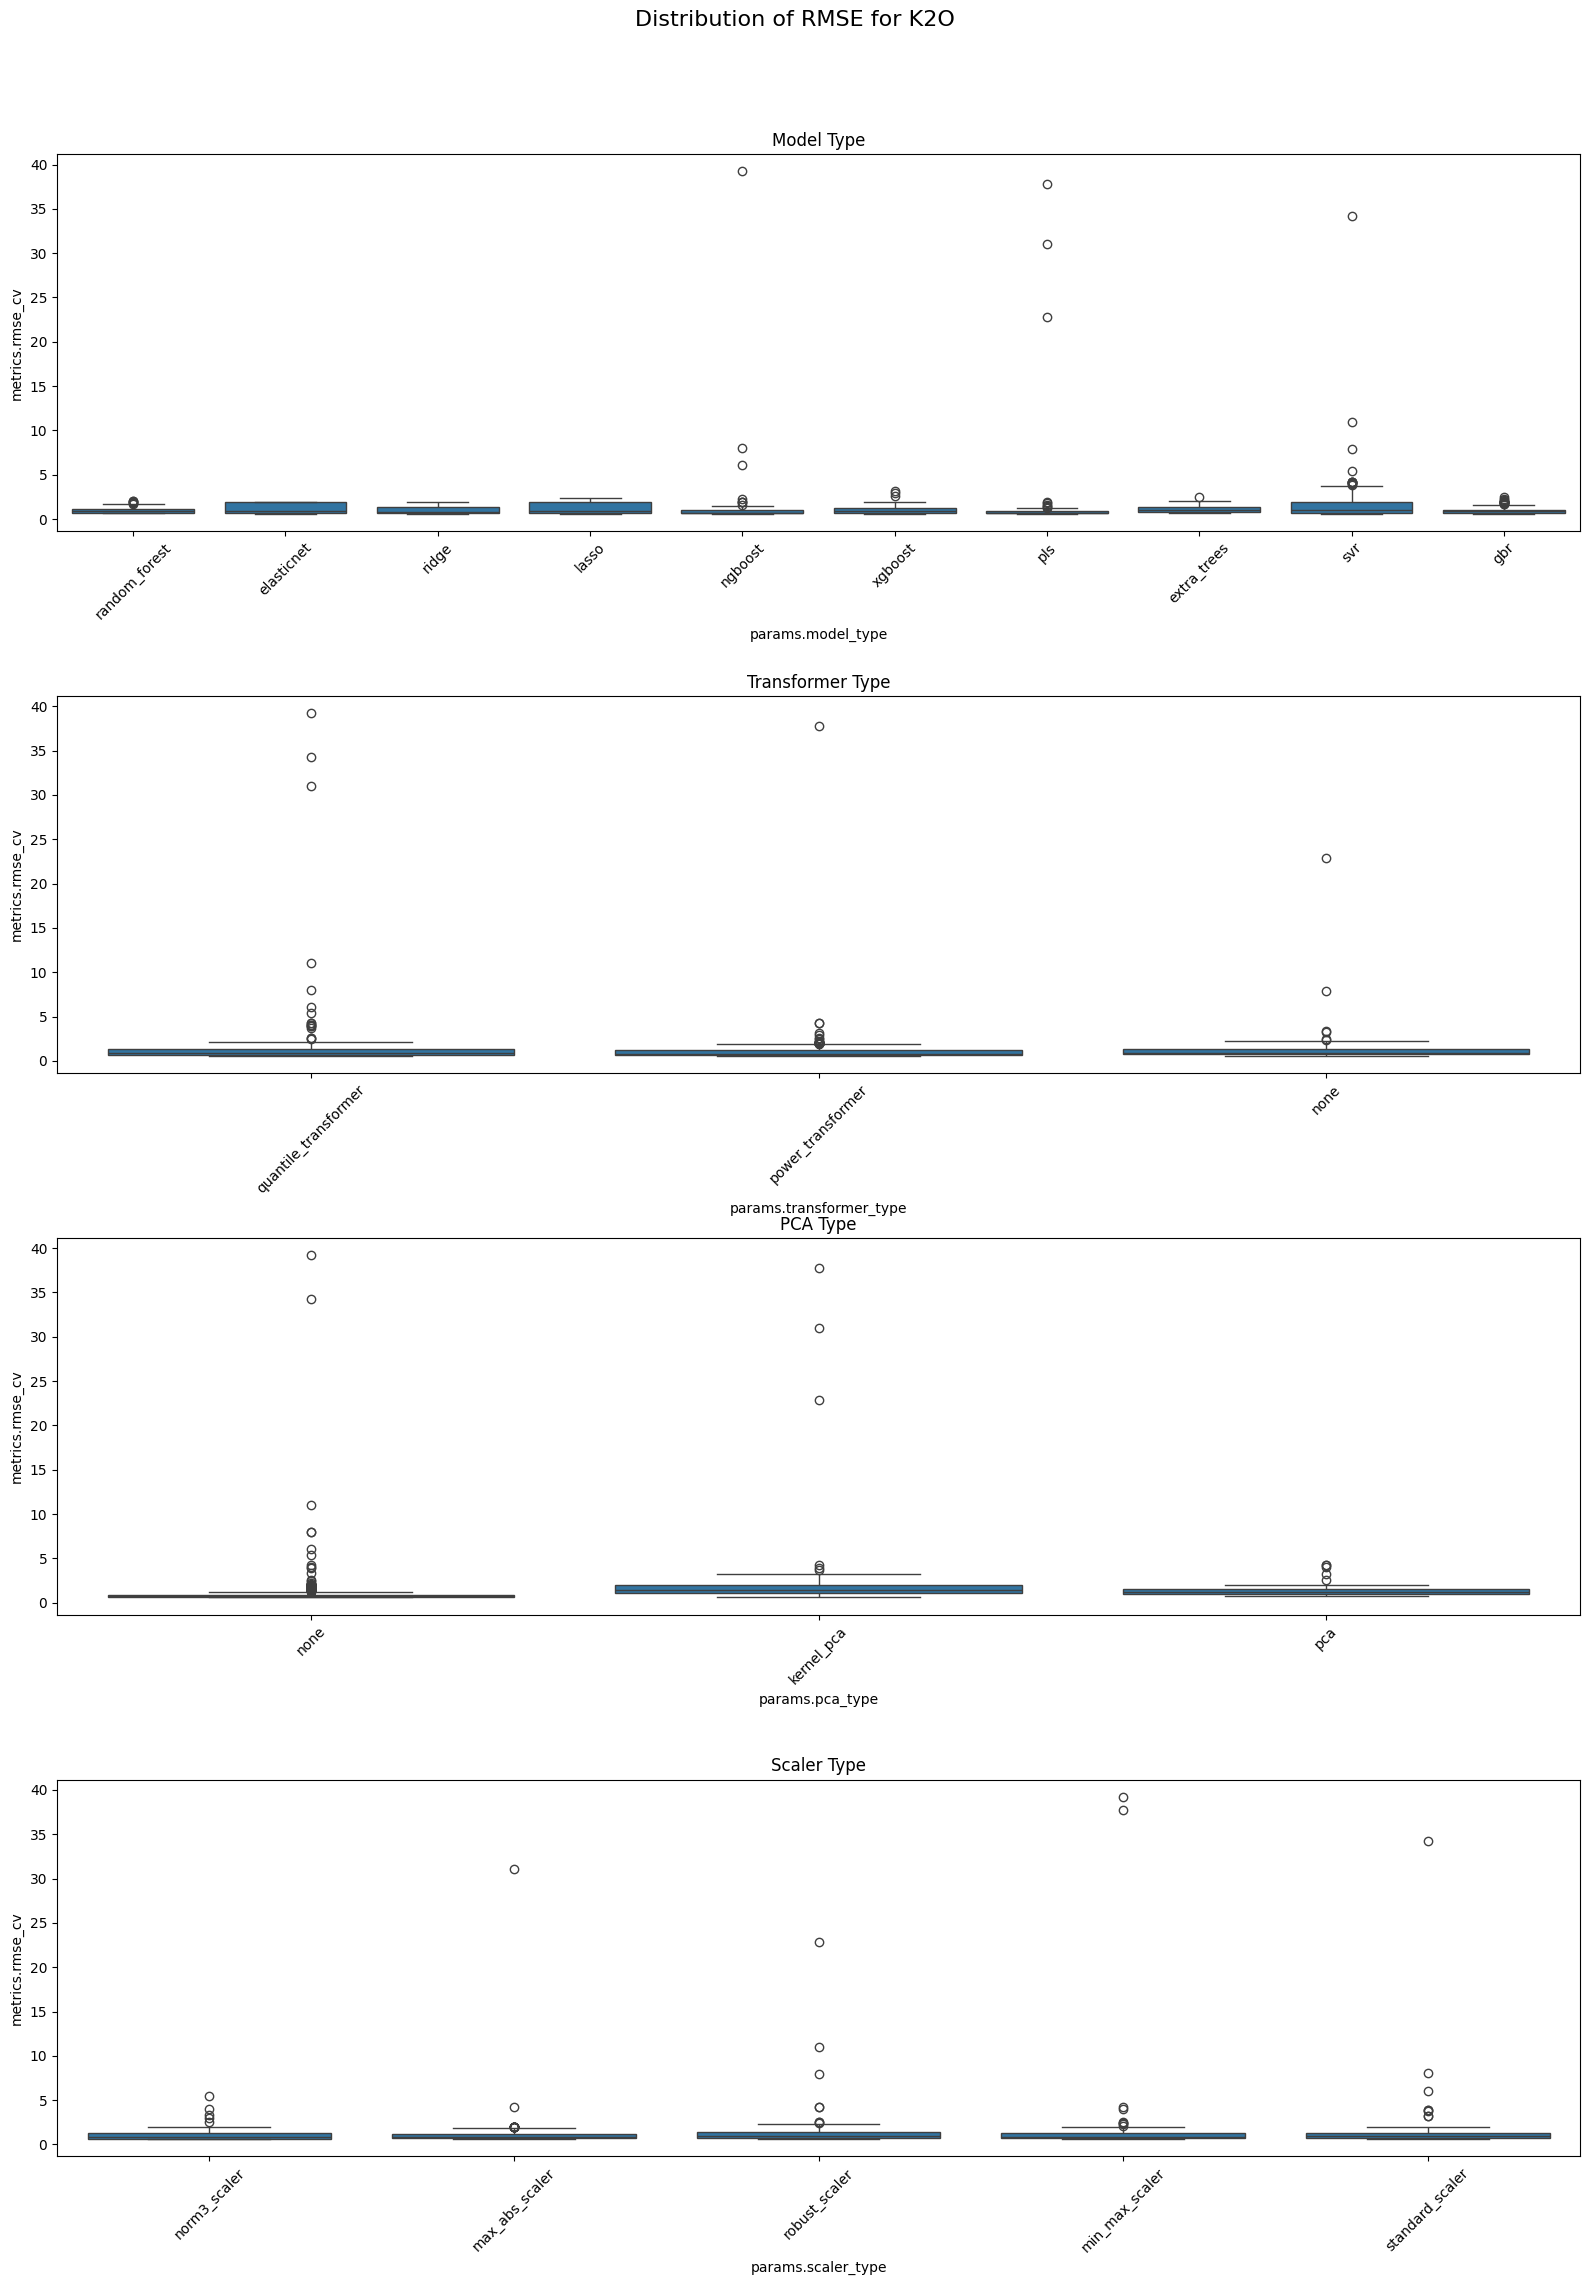

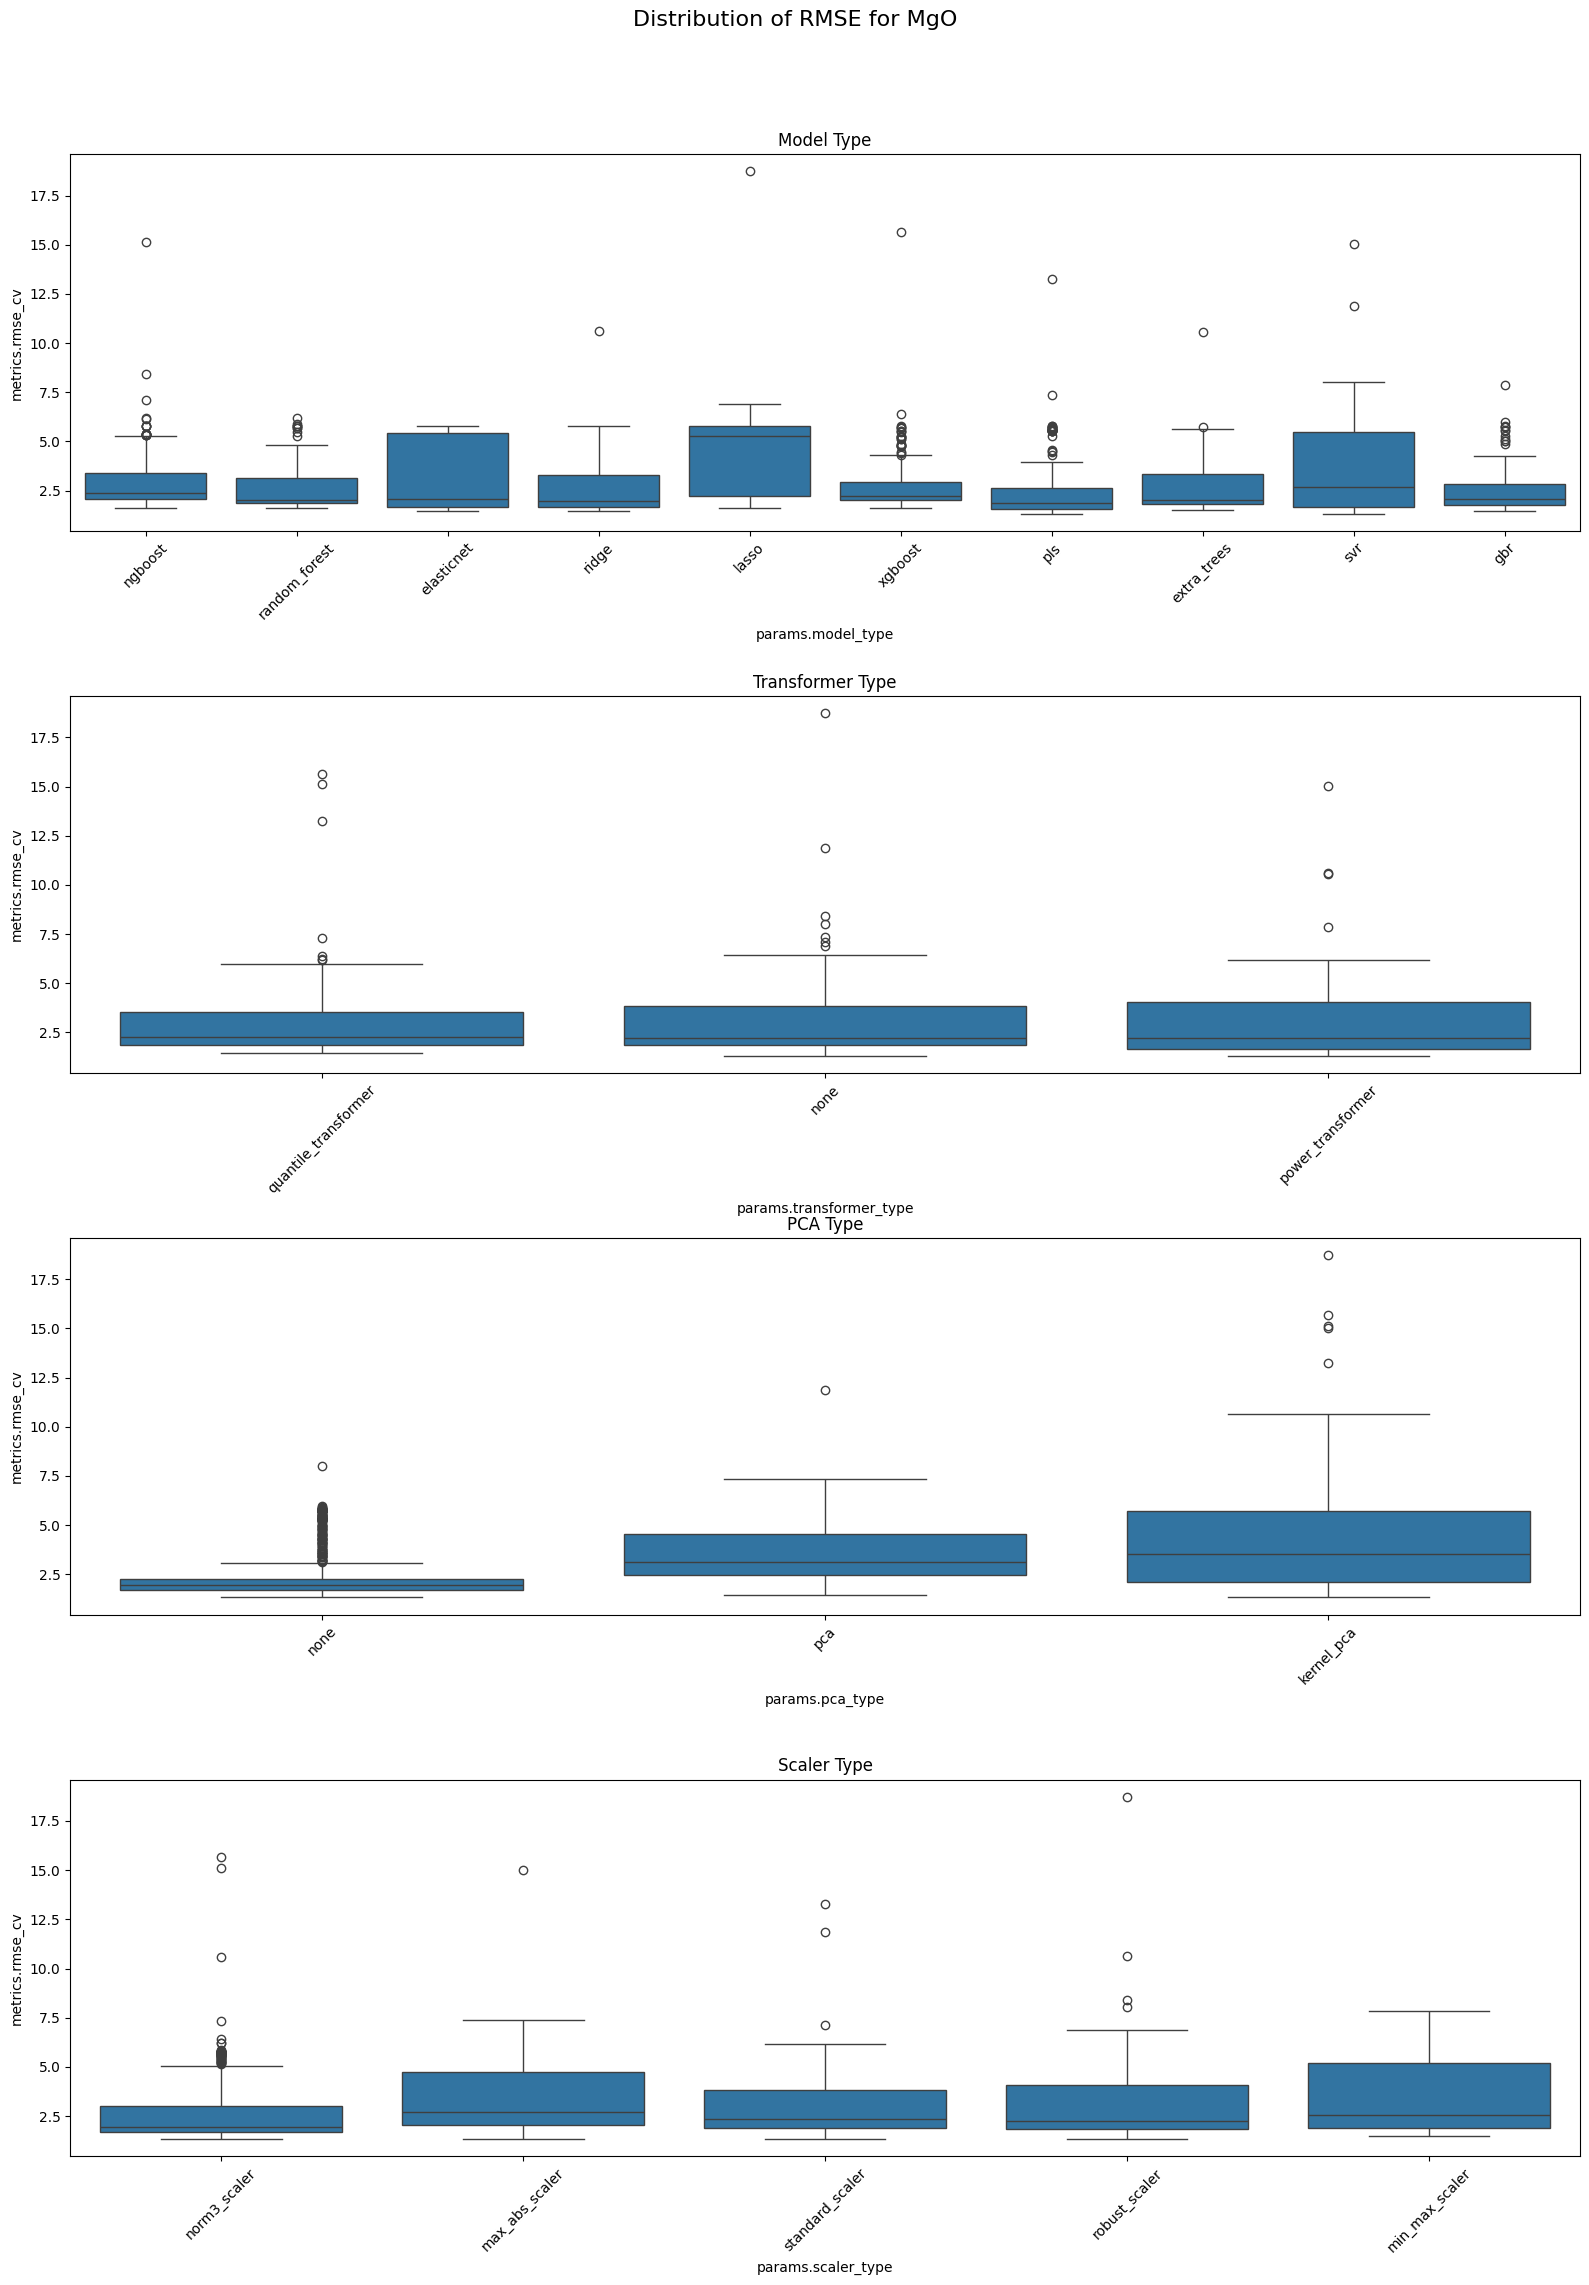

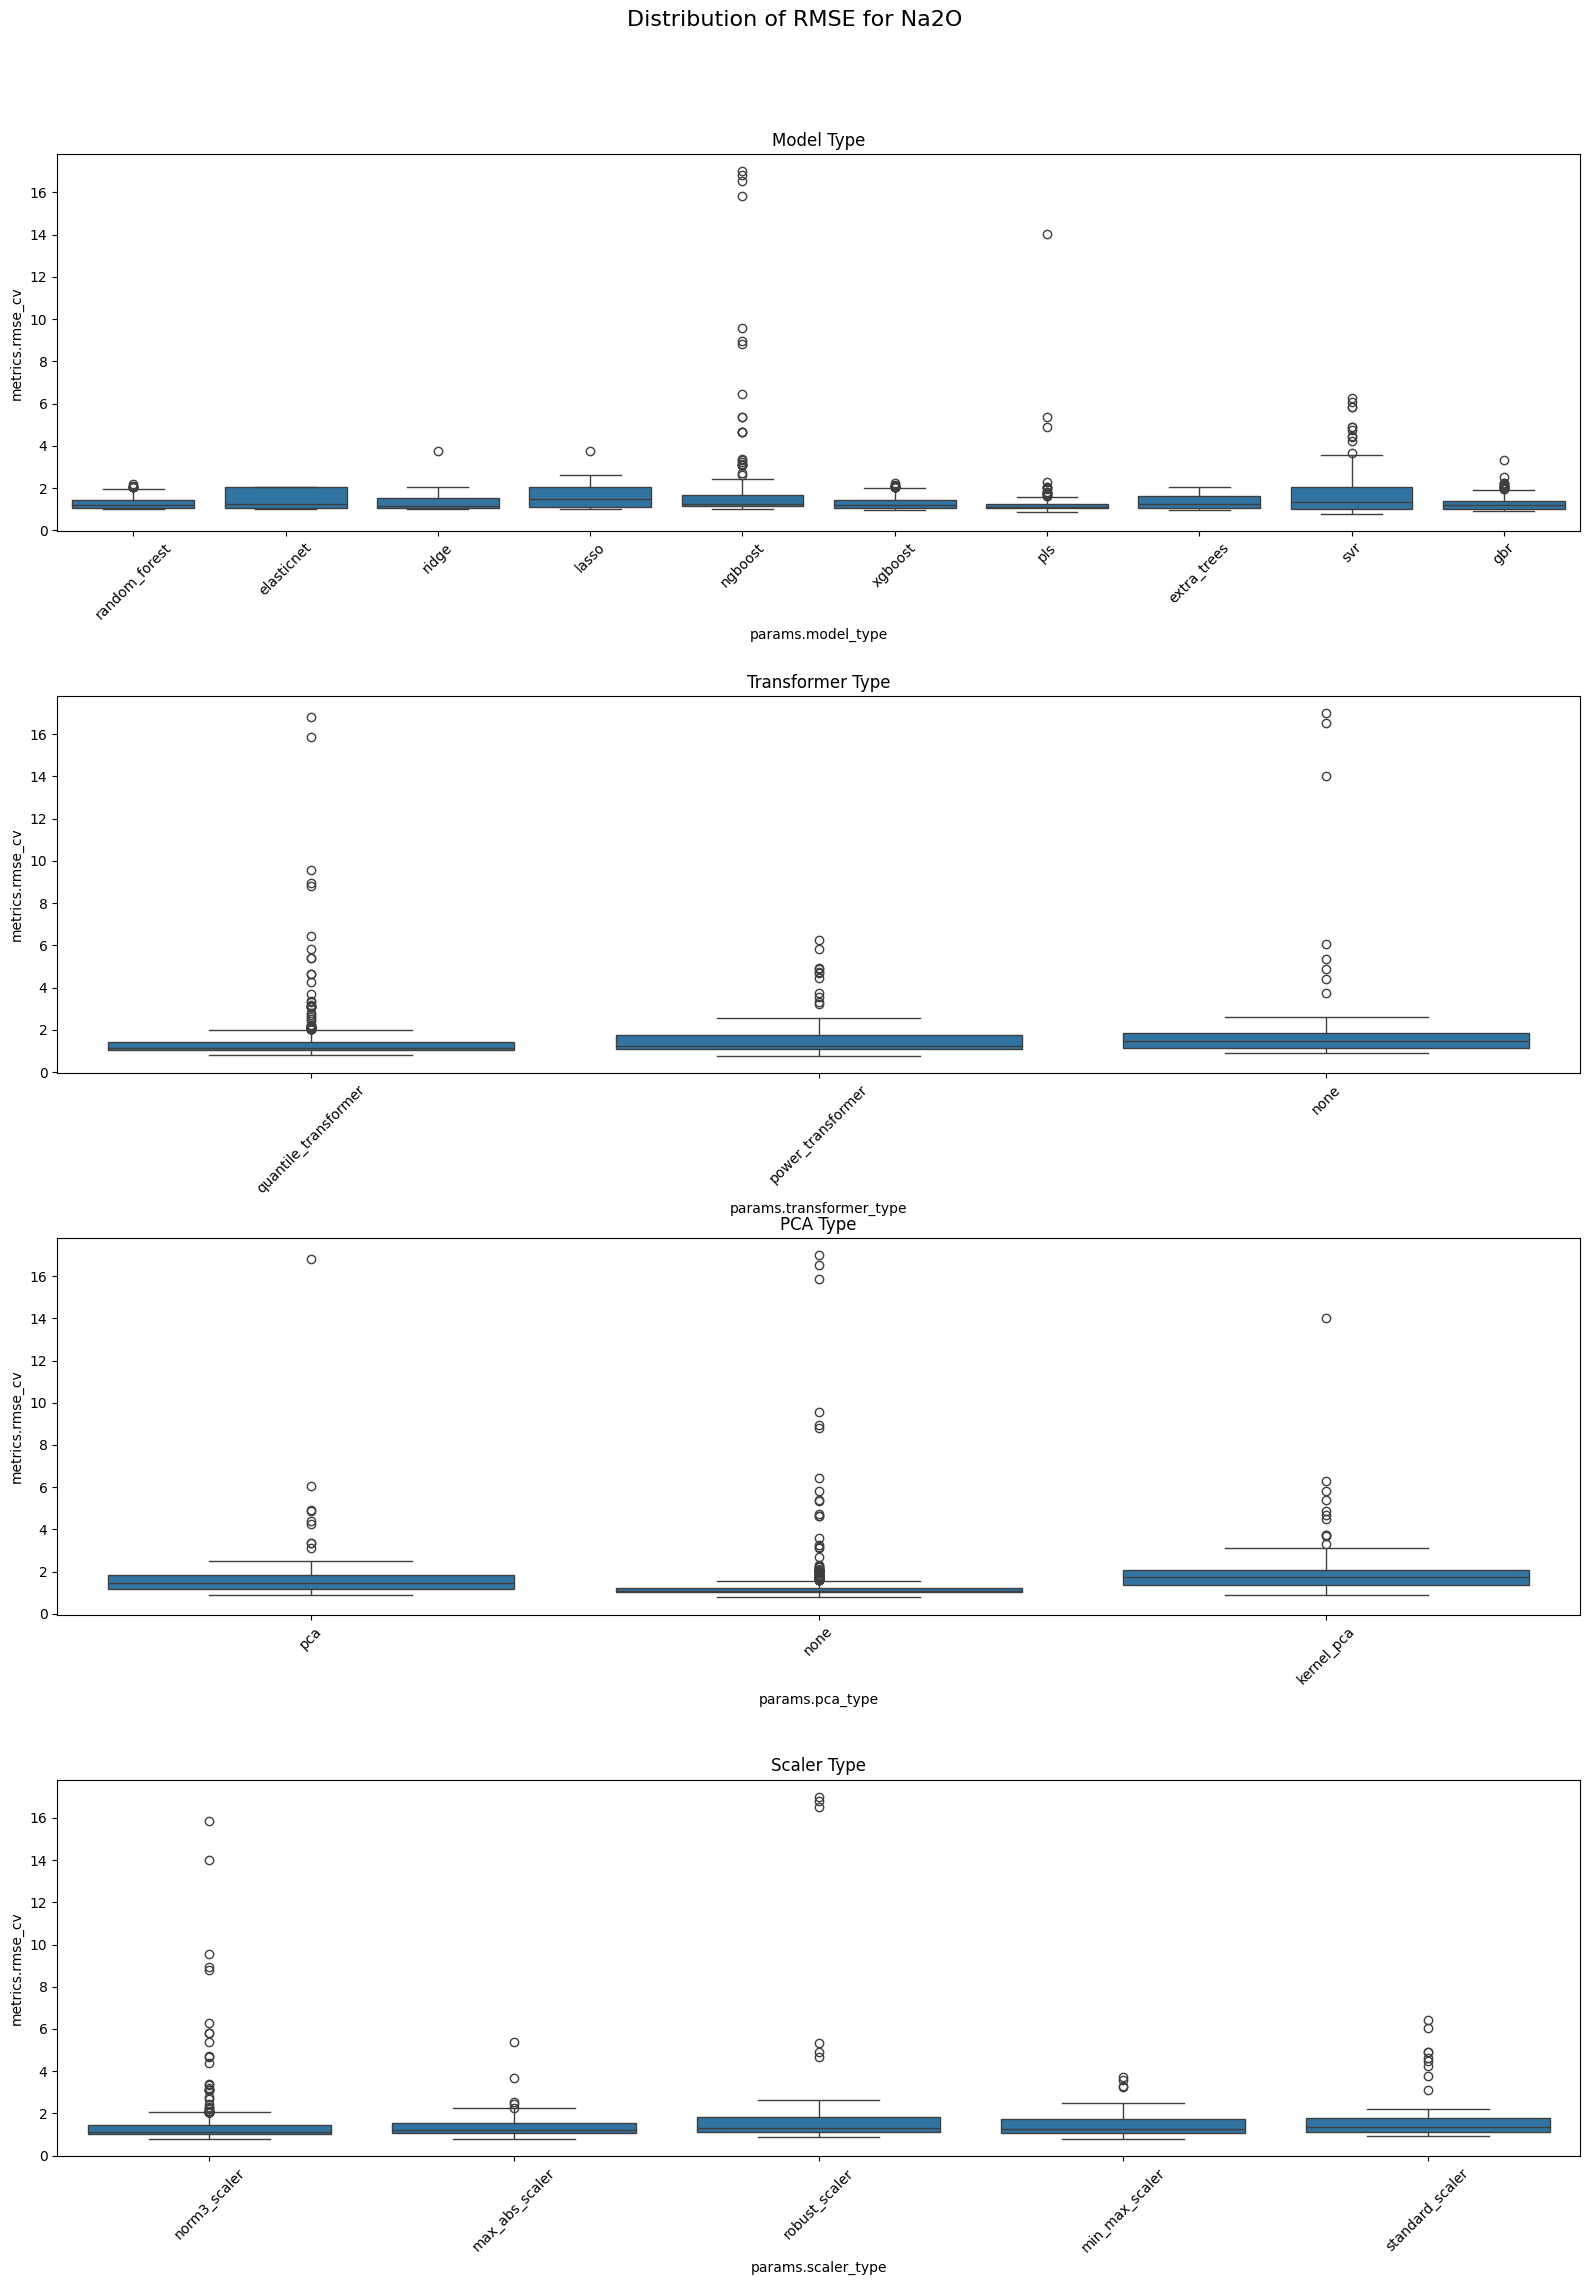

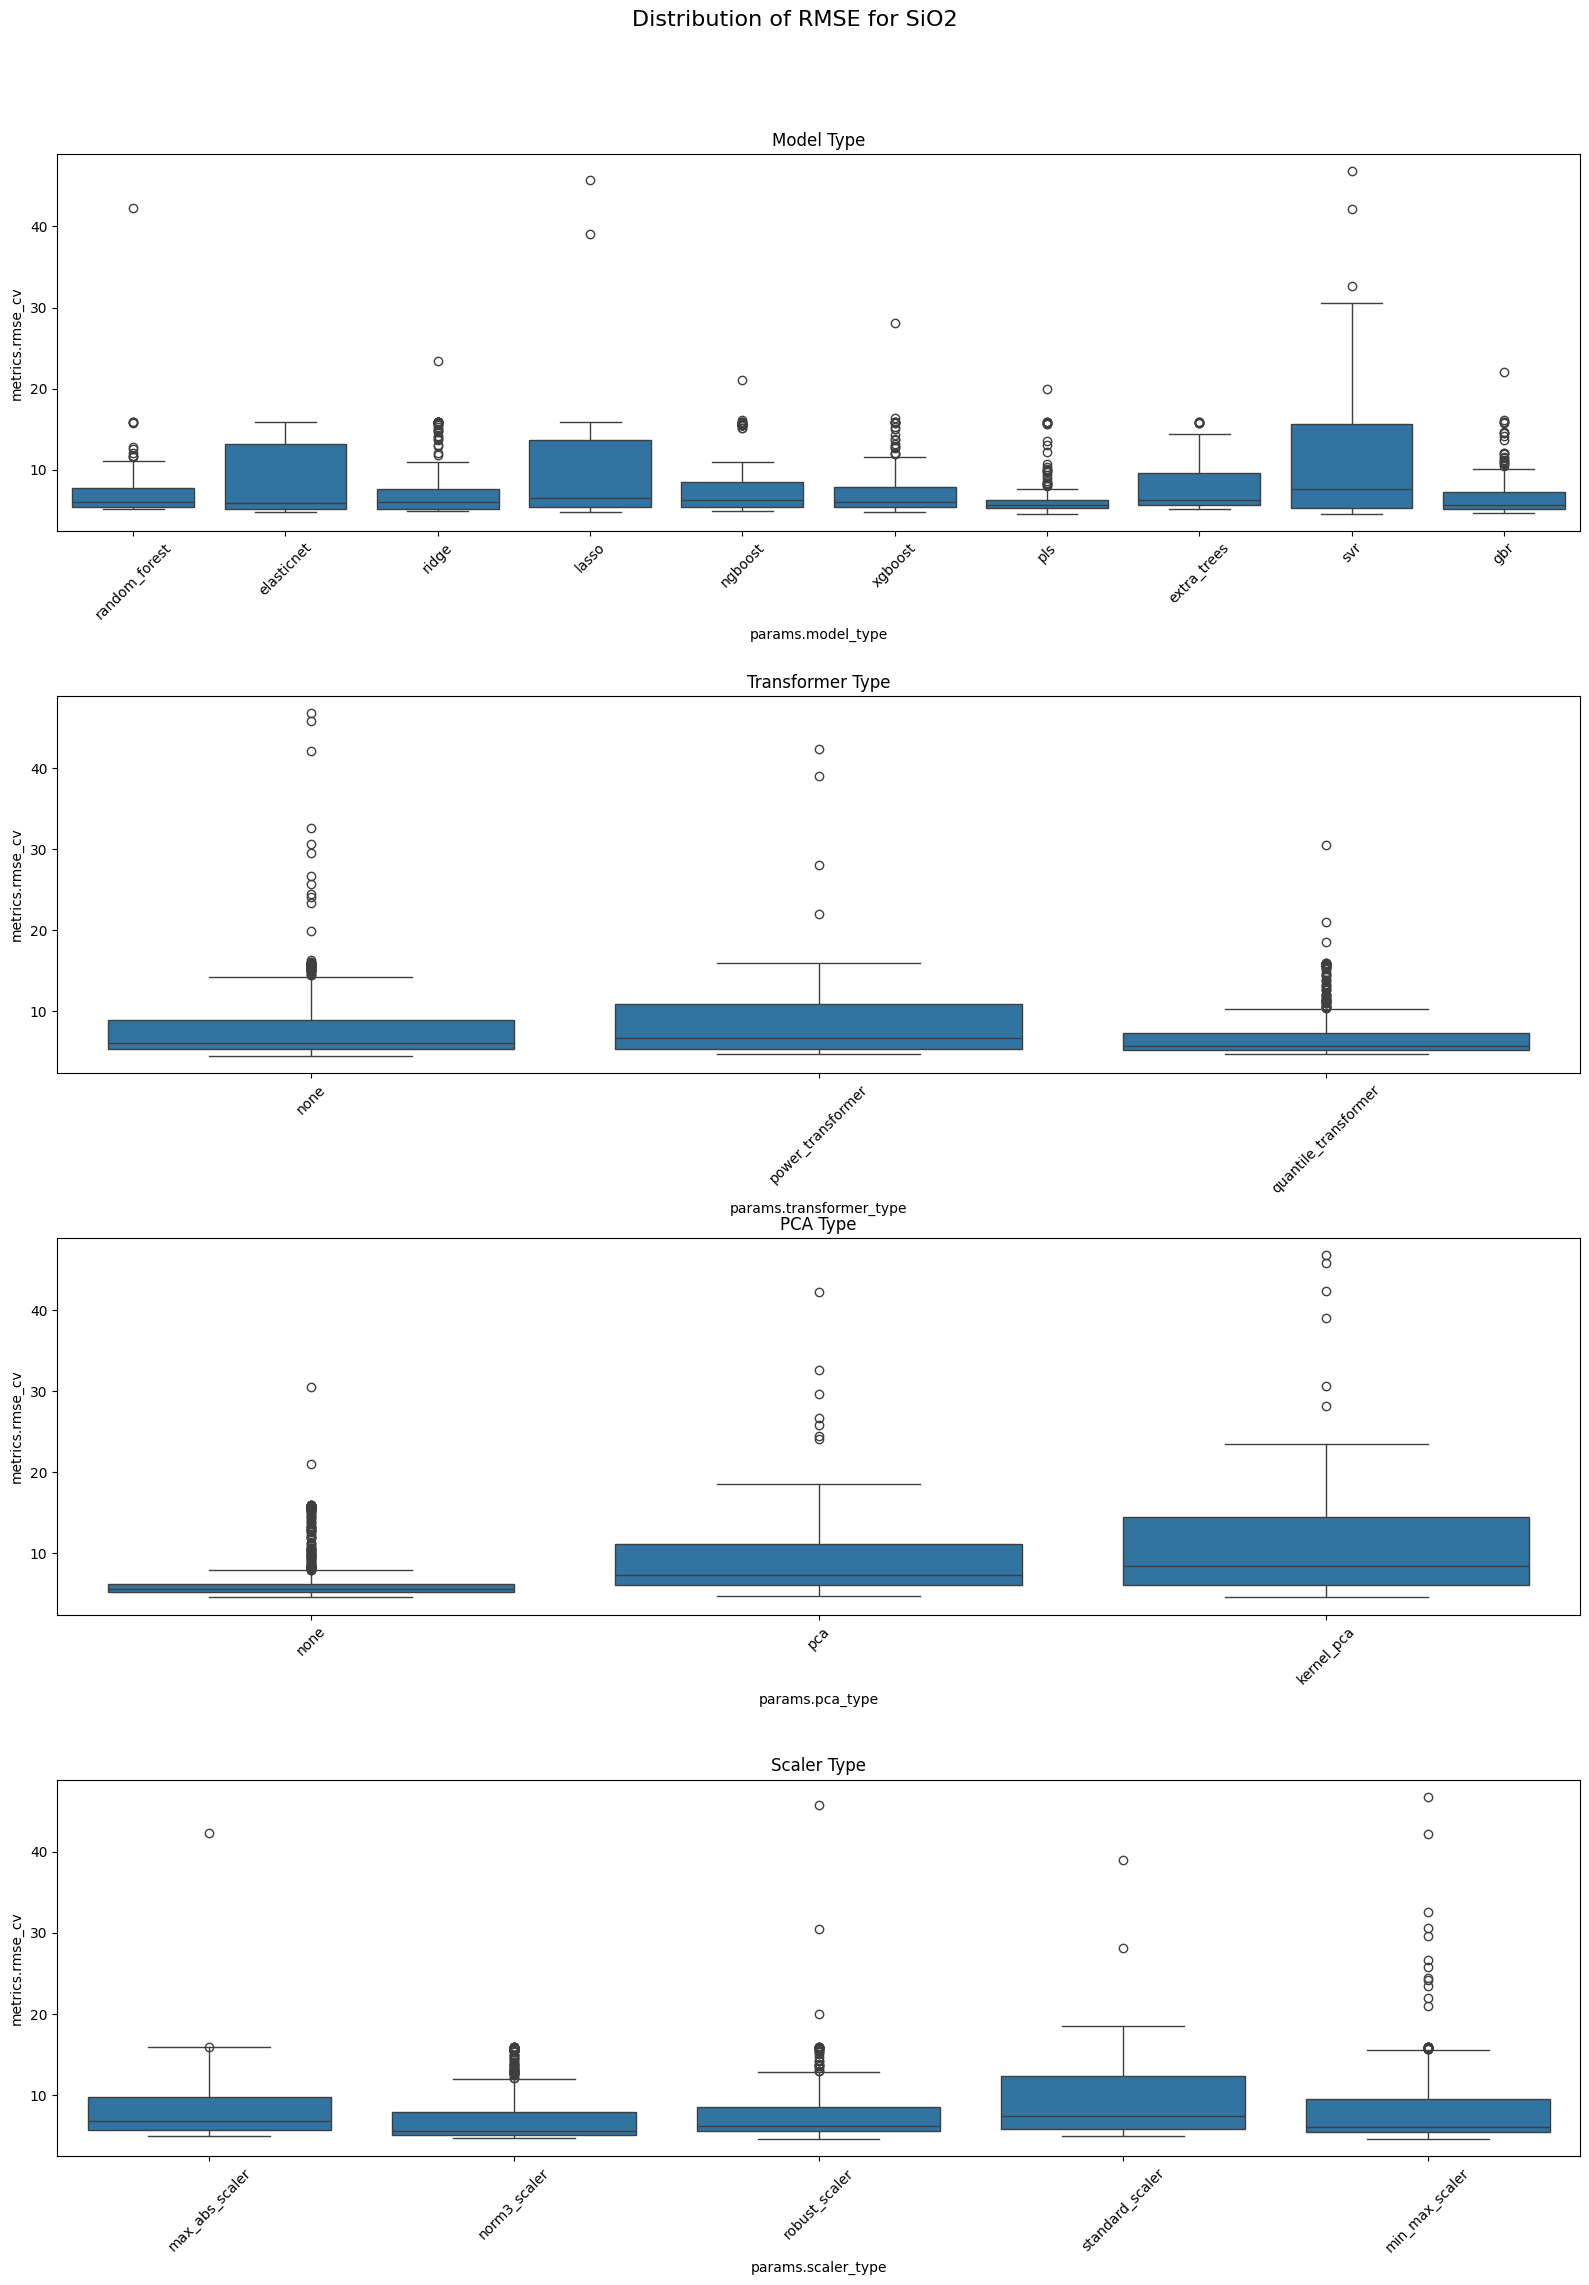

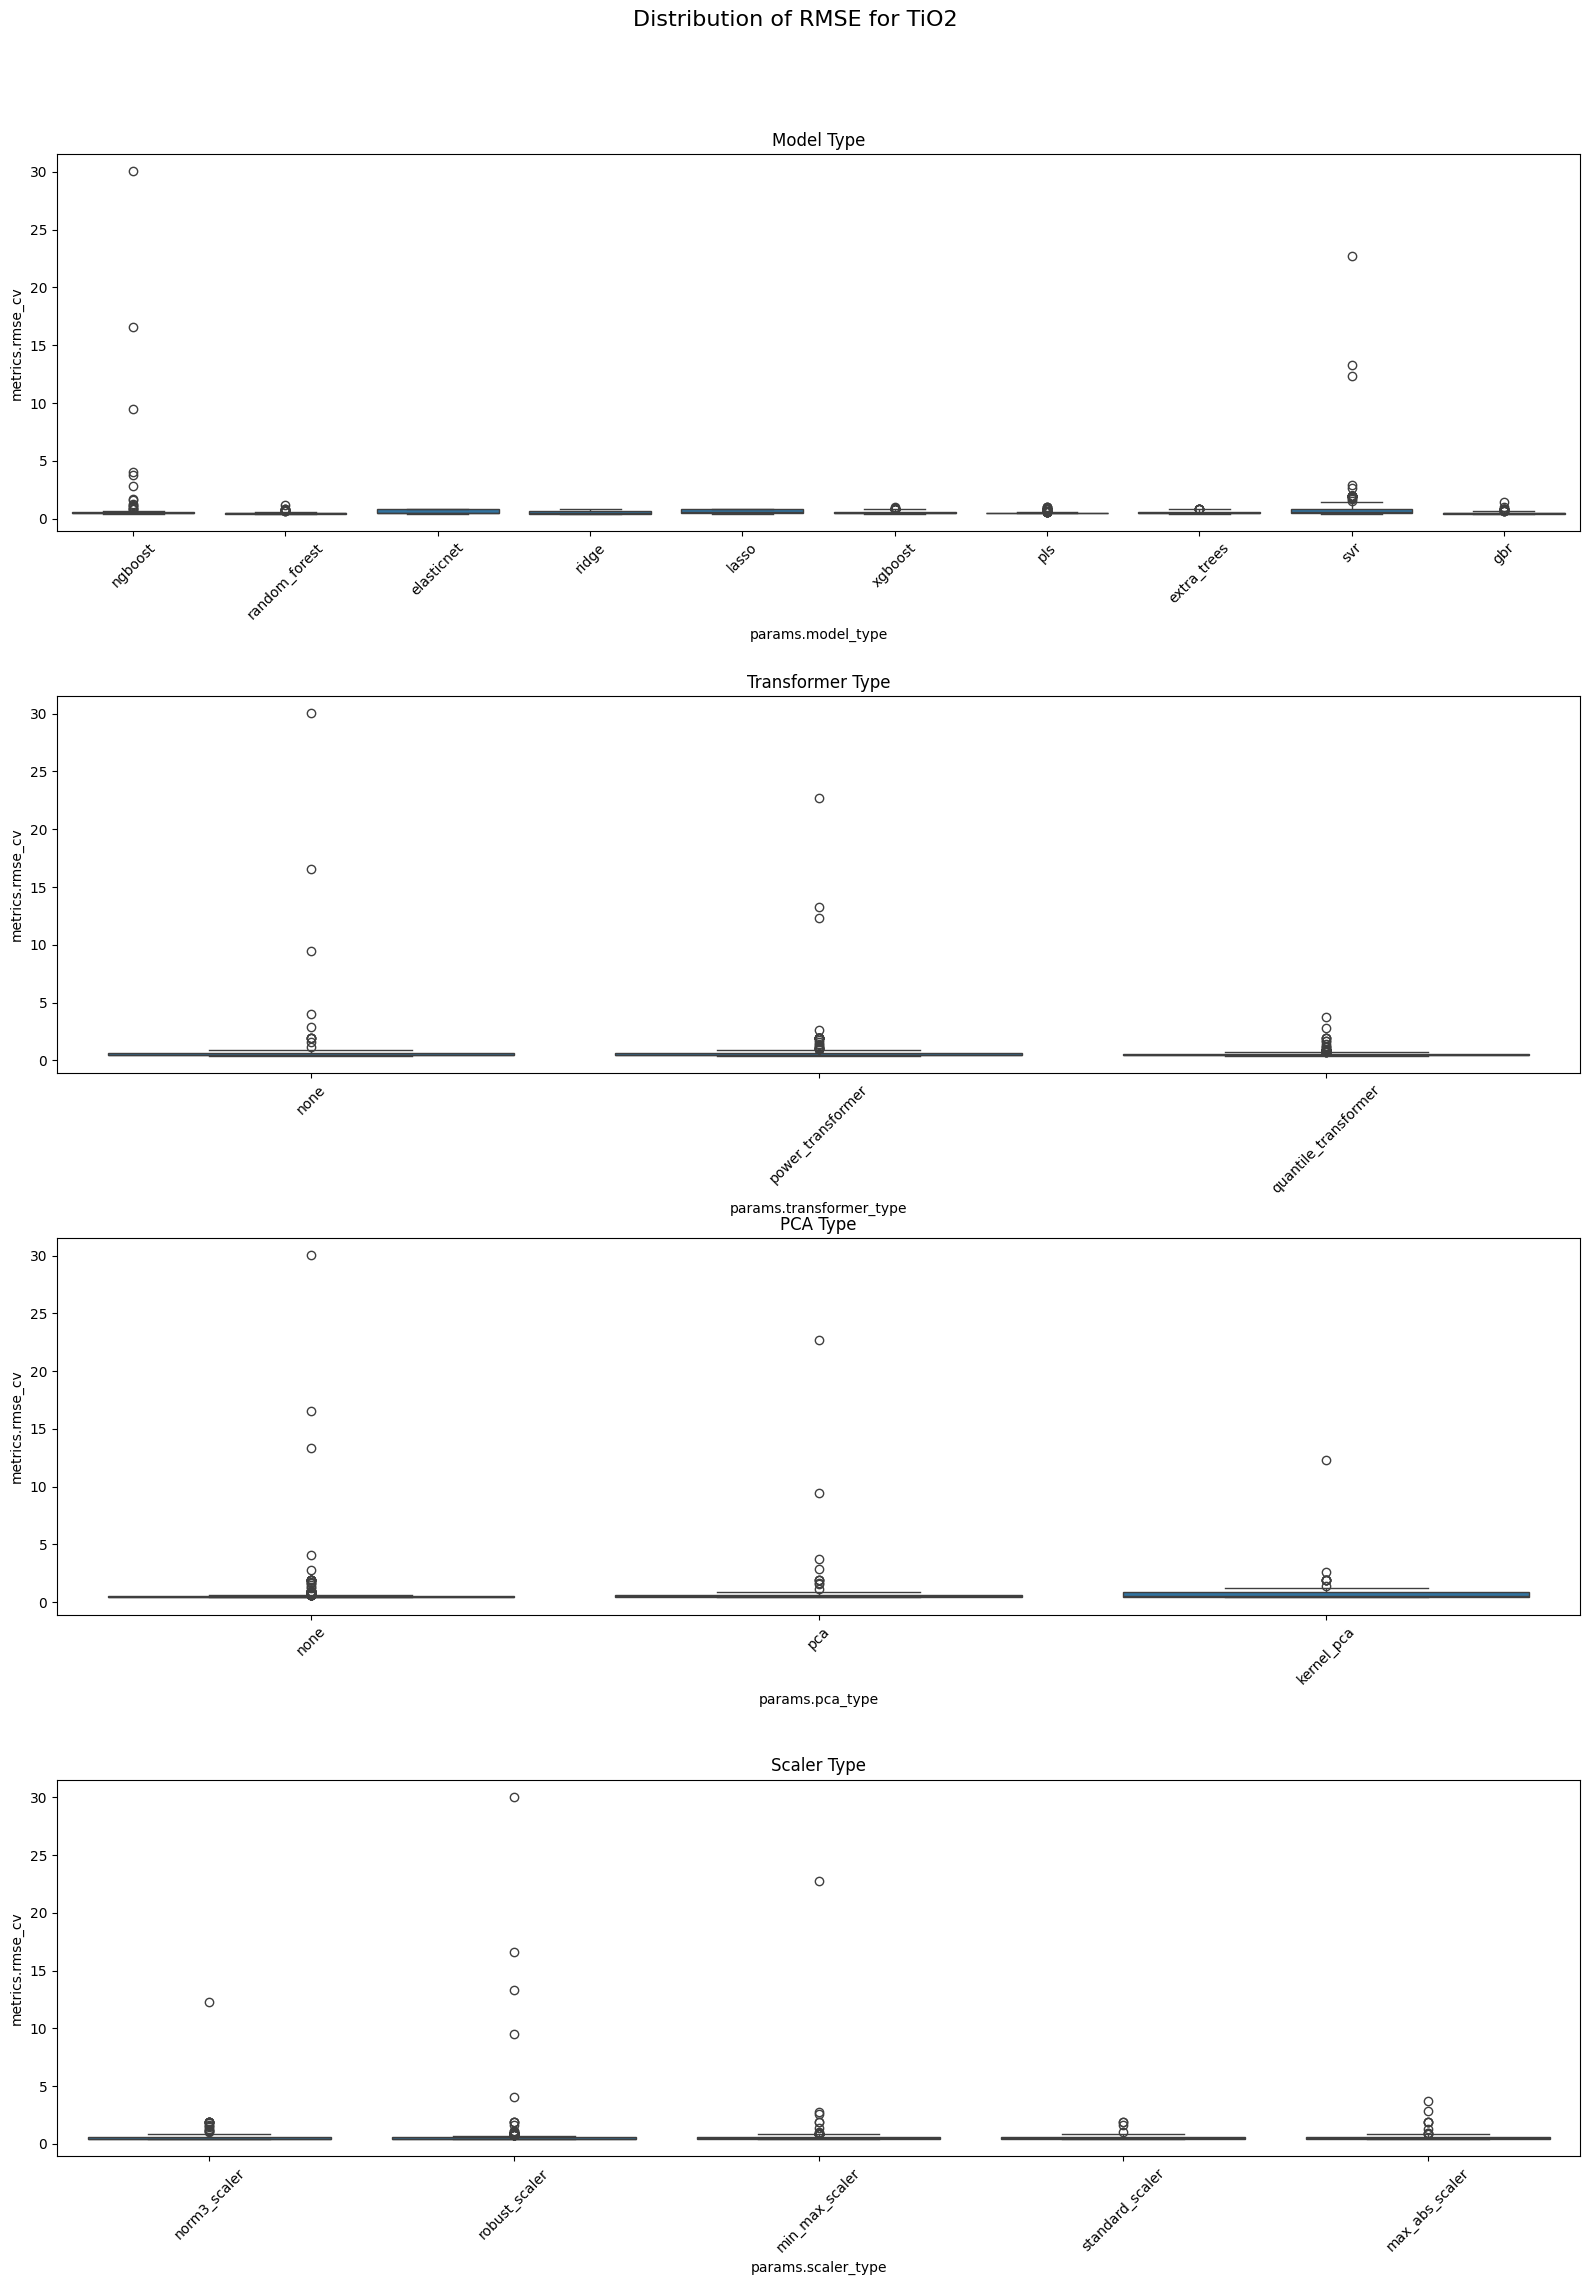

In [39]:
# Function to create box plots for each params.oxide
def create_box_plots(df):
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        plt.figure(figsize=(16, 24))  # Increased width from 16 to 24
        plt.suptitle(f'Distribution of RMSE for {oxide}', fontsize=16)

        # Box plot for params.model_type
        plt.subplot(4, 1, 1)
        sns.boxplot(x='params.model_type', y='metrics.rmse_cv', data=group)
        plt.title('Model Type')
        plt.xticks(rotation=45)
        
        # Box plot for params.transformer_type
        plt.subplot(4, 1, 2)
        sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', data=group)
        plt.title('Transformer Type')
        plt.xticks(rotation=45)
        
        # Box plot for params.pca_type
        plt.subplot(4, 1, 3)
        sns.boxplot(x='params.pca_type', y='metrics.rmse_cv', data=group)
        plt.title('PCA Type')
        plt.xticks(rotation=45)
        
        # Box plot for params.scaler_type
        plt.subplot(4, 1, 4)
        sns.boxplot(x='params.scaler_type', y='metrics.rmse_cv', data=group)
        plt.title('Scaler Type')
        plt.xticks(rotation=45)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95], w_pad=0, h_pad=0)
        plt.show()

# Create box plots
create_box_plots(filtered_runs)

In [40]:
import pandas as pd
import scipy.stats as stats

# Function to perform Kruskal-Wallis H test
def analyze_correlations(df):
    results = []
    
    # Group by params.oxide
    grouped = df.groupby('params.oxide')
    
    for oxide, group in grouped:
        kw_results = {}
        for param in ['params.model_type', 'params.transformer_type', 'params.pca_type', 'params.scaler_type']:
            groups = [group['metrics.rmse_cv'][group[param] == level].values for level in group[param].unique()]
            if len(groups) > 1:  # Kruskal-Wallis test requires at least 2 groups
                stat, p_value = stats.kruskal(*groups)
                kw_results[param] = p_value
        
        # Identify the configuration with the lowest p-value
        best_param = min(kw_results, key=kw_results.get)
        results.append({
            'oxide': oxide,
            'best_param': best_param,
            'p_value': kw_results[best_param]
        })
    
    return pd.DataFrame(results)

# Load your data into df
# df = pd.read_csv('your_dataset.csv')

# Run the analysis
results_df = analyze_correlations(runs_filtered)


In [41]:
results_df

,oxide,best_param,p_value
0,Al2O3,params.pca_type,6.341297e-122
1,CaO,params.pca_type,4.241883e-156
2,FeOT,params.pca_type,8.601464e-118
3,K2O,params.pca_type,1.430096e-143
4,MgO,params.pca_type,2.508525e-86
5,Na2O,params.pca_type,2.142521e-126
6,SiO2,params.pca_type,1.462530e-82
7,TiO2,params.pca_type,5.551974e-92


In [59]:
out = runs.groupby(['params.transformer_type', 'params.model_type', 'params.oxide']).size().reset_index(name='count')
pivot_table = out.pivot(index='params.oxide', columns=['params.transformer_type', 'params.model_type'], values='count')

# Add a total count for each transformer_type and oxide
out_total = runs.groupby(['params.transformer_type', 'params.oxide']).size().reset_index(name='total_count')
for transformer_type in out['params.transformer_type'].unique():
    pivot_table[(transformer_type, 'total_count')] = out_total[out_total['params.transformer_type'] == transformer_type].set_index('params.oxide')['total_count']

# Add a total count across all oxides for each transformer_type
total_across_oxides = out_total.groupby('params.transformer_type')['total_count'].sum()
for transformer_type in total_across_oxides.index:
    pivot_table.loc['total_across_oxides', (transformer_type, 'total_count')] = total_across_oxides[transformer_type]

# Only show the total counts
total_counts = pivot_table.xs('total_count', level=1, axis=1)
total_counts.T

# pivot_table.T

params.oxide,Al2O3,CaO,FeOT,K2O,MgO,Na2O,SiO2,TiO2,total_across_oxides
params.transformer_type,,,,,,,,,
none,442.0,673.0,633.0,504.0,725.0,441.0,760.0,778.0,4956.0
power_transformer,649.0,595.0,644.0,822.0,701.0,583.0,566.0,717.0,5277.0
quantile_transformer,909.0,732.0,723.0,674.0,517.0,976.0,674.0,505.0,5710.0


In [60]:
out = runs.groupby(['params.pca_type', 'params.model_type', 'params.oxide']).size().reset_index(name='count')
pivot_table = out.pivot(index='params.oxide', columns=['params.pca_type', 'params.model_type'], values='count')

# Add a total count for each pca_type and oxide
out_total = runs.groupby(['params.pca_type', 'params.oxide']).size().reset_index(name='total_count')
for pca_type in out['params.pca_type'].unique():
    pivot_table[(pca_type, 'total_count')] = out_total[out_total['params.pca_type'] == pca_type].set_index('params.oxide')['total_count']

# Add a total count across all oxides for each pca_type
total_across_oxides = out_total.groupby('params.pca_type')['total_count'].sum()
for pca_type in total_across_oxides.index:
    pivot_table.loc['total_across_oxides', (pca_type, 'total_count')] = total_across_oxides[pca_type]

# pivot_table.T

total_counts = pivot_table.xs('total_count', level=1, axis=1)
total_counts.T

params.oxide,Al2O3,CaO,FeOT,K2O,MgO,Na2O,SiO2,TiO2,total_across_oxides
params.pca_type,,,,,,,,,
kernel_pca,389.0,374.0,382.0,373.0,543.0,382.0,457.0,468.0,3368.0
none,1243.0,1246.0,1217.0,1250.0,1037.0,1167.0,1096.0,1163.0,9419.0
pca,368.0,380.0,401.0,377.0,363.0,451.0,447.0,369.0,3156.0


In [61]:
out = runs.groupby(['params.scaler_type', 'params.model_type', 'params.oxide']).size().reset_index(name='count')
pivot_table = out.pivot(index='params.oxide', columns=['params.scaler_type', 'params.model_type'], values='count')

# Add a total count for each scaler_type and oxide
out_total = runs.groupby(['params.scaler_type', 'params.oxide']).size().reset_index(name='total_count')
for scaler_type in out['params.scaler_type'].unique():
    pivot_table[(scaler_type, 'total_count')] = out_total[out_total['params.scaler_type'] == scaler_type].set_index('params.oxide')['total_count']

# Add a total count across all oxides for each scaler_type
total_across_oxides = out_total.groupby('params.scaler_type')['total_count'].sum()
for scaler_type in total_across_oxides.index:
    pivot_table.loc['total_across_oxides', (scaler_type, 'total_count')] = total_across_oxides[scaler_type]

# pivot_table.T

total_counts = pivot_table.xs('total_count', level=1, axis=1)
total_counts.T

params.oxide,Al2O3,CaO,FeOT,K2O,MgO,Na2O,SiO2,TiO2,total_across_oxides
params.scaler_type,,,,,,,,,
max_abs_scaler,336.0,310.0,498.0,258.0,239.0,316.0,221.0,280.0,2458.0
min_max_scaler,476.0,362.0,287.0,320.0,340.0,327.0,421.0,322.0,2855.0
norm3_scaler,495.0,681.0,561.0,622.0,646.0,748.0,830.0,507.0,5090.0
robust_scaler,453.0,338.0,339.0,430.0,413.0,320.0,309.0,565.0,3167.0
standard_scaler,240.0,309.0,315.0,370.0,305.0,289.0,219.0,326.0,2373.0


In [43]:
# Define a threshold to filter out the extremely high RMSE values as outliers
threshold = 15

# Filter out rows with NaN values in 'params.transformer_type' and 'params.model_type'
filtered_data = runs.dropna(subset=['params.transformer_type', 'params.model_type'])

# Filter the data to remove outliers
filtered_data = filtered_data[filtered_data['metrics.rmse_cv'] < threshold]

# Calculate the mean RMSE for each combination of transformer type, model type, and oxide using 'metrics.rmse_cv'
mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()

# Calculate the overall mean RMSE for each combination of transformer type and model type using 'metrics.rmse_cv'
overall_mean_rmse_cv = filtered_data.groupby(['params.transformer_type', 'params.model_type'])['metrics.rmse_cv'].mean().reset_index()

mean_rmse_cv


,params.transformer_type,params.model_type,params.oxide,metrics.rmse_cv
0,none,elasticnet,Al2O3,5.461631
1,none,elasticnet,CaO,5.455882
2,none,elasticnet,FeOT,5.458367
3,none,elasticnet,K2O,1.523440
4,none,elasticnet,MgO,4.004144
...,...,...,...,...
235,quantile_transformer,xgboost,K2O,1.108091
236,quantile_transformer,xgboost,MgO,2.961538
237,quantile_transformer,xgboost,Na2O,1.284493
238,quantile_transformer,xgboost,SiO2,6.641999


In [44]:
overall_mean_rmse_cv

,params.transformer_type,params.model_type,metrics.rmse_cv
0,none,elasticnet,3.279757
1,none,extra_trees,3.332615
2,none,gbr,2.739534
3,none,lasso,3.933685
4,none,ngboost,2.746290
5,none,pls,2.764185
6,none,random_forest,2.955976
7,none,ridge,2.861413
8,none,svr,4.419211
9,none,xgboost,2.564033


In [45]:
overall_mean_rmse_cv.groupby(['params.transformer_type'])['metrics.rmse_cv'].mean().reset_index()

,params.transformer_type,metrics.rmse_cv
0,none,3.159670
1,power_transformer,2.765937
2,quantile_transformer,2.834634


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group and pivot the data
teste = mean_rmse_cv.groupby(['params.transformer_type', 'params.oxide'])['metrics.rmse_cv'].mean().reset_index()
pivot_table = teste.pivot(index='params.oxide', columns='params.transformer_type', values='metrics.rmse_cv')
pivot_table

params.transformer_type,none,power_transformer,quantile_transformer
params.oxide,,,
Al2O3,4.191592,3.782426,3.314876
CaO,3.376023,2.769860,3.074937
FeOT,4.423880,4.308292,4.155834
K2O,1.201299,1.001218,1.080698
MgO,3.089719,3.088949,3.063810
Na2O,1.597966,1.442915,1.406117
SiO2,6.961690,7.308133,6.518524
TiO2,0.581660,0.593364,0.614327


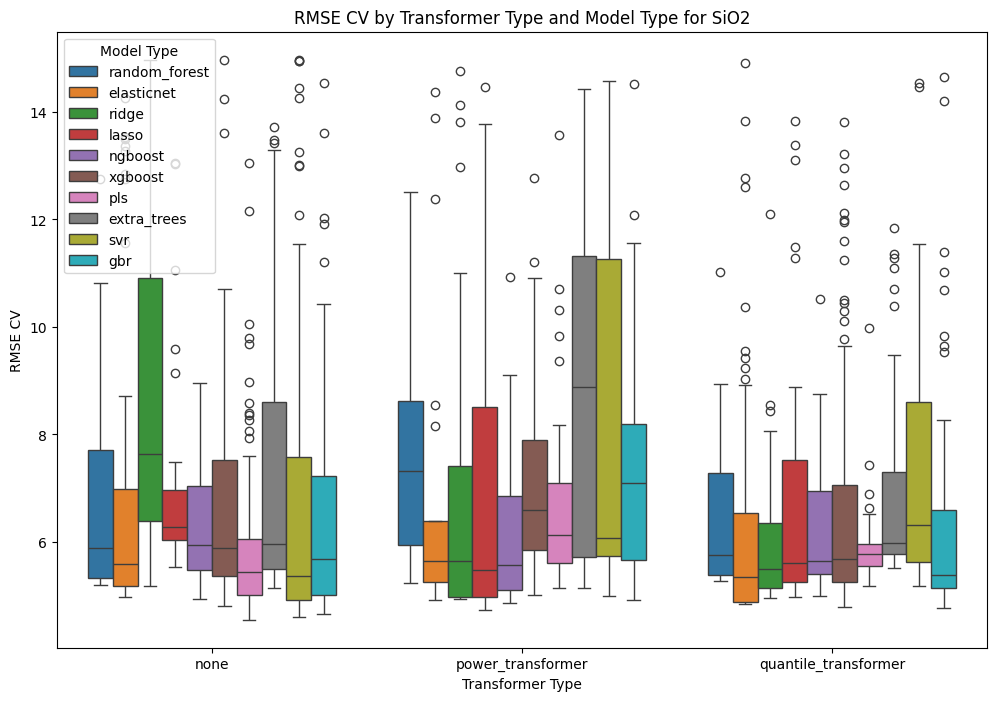

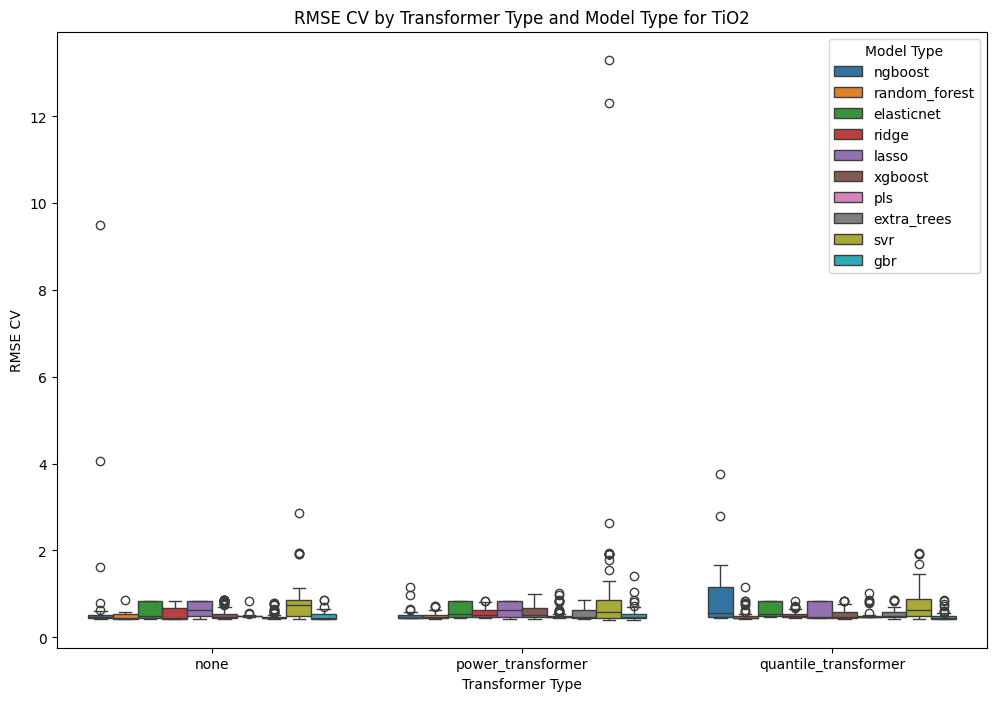

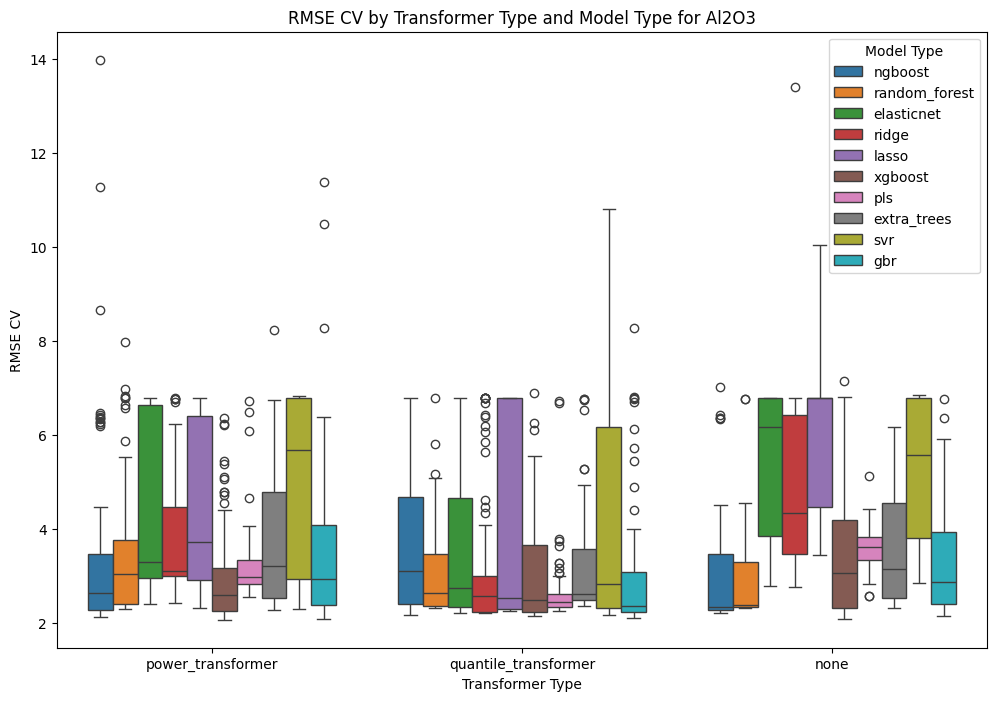

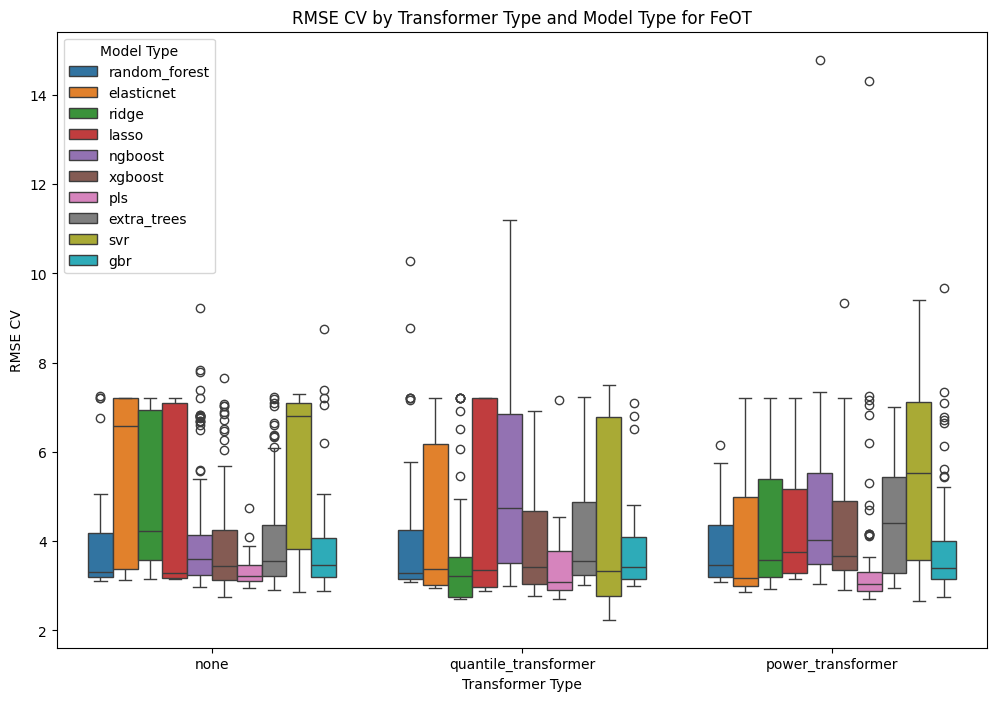

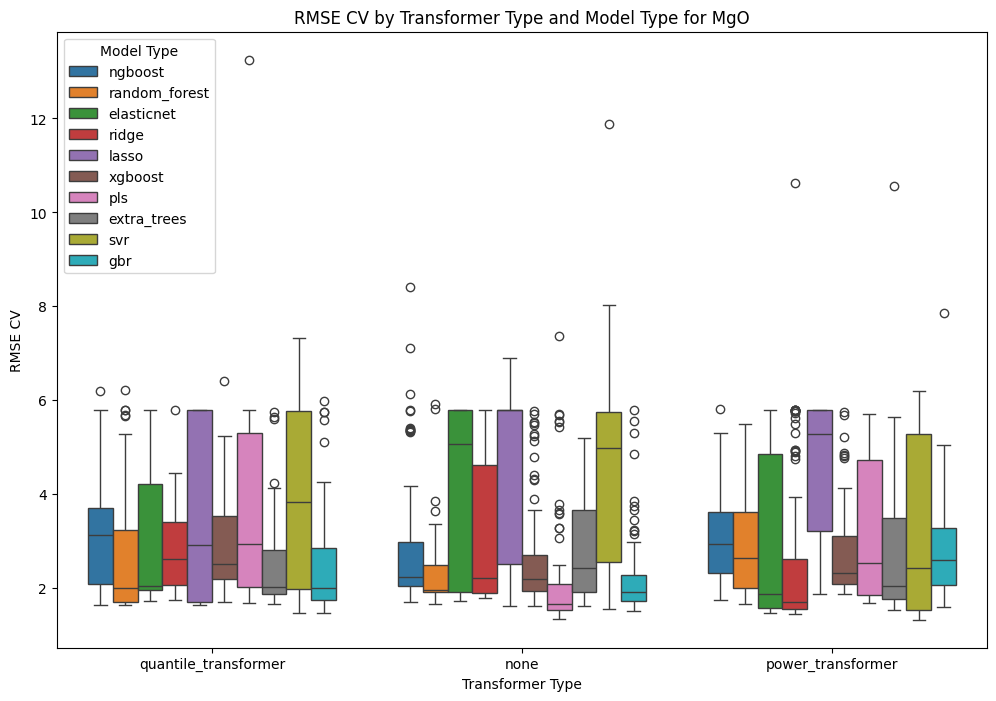

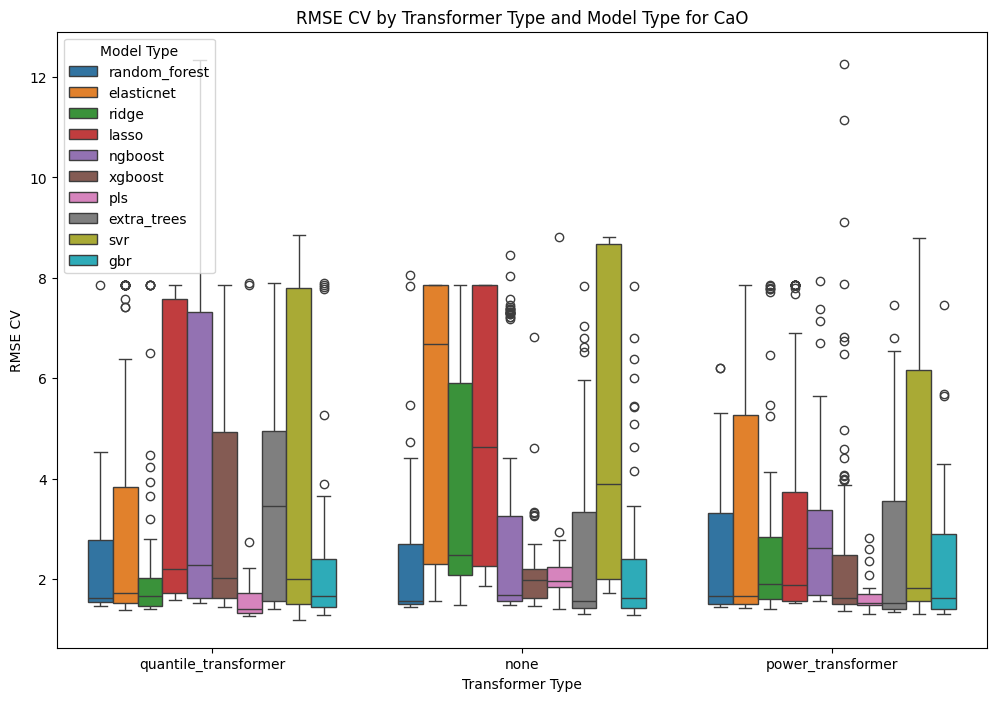

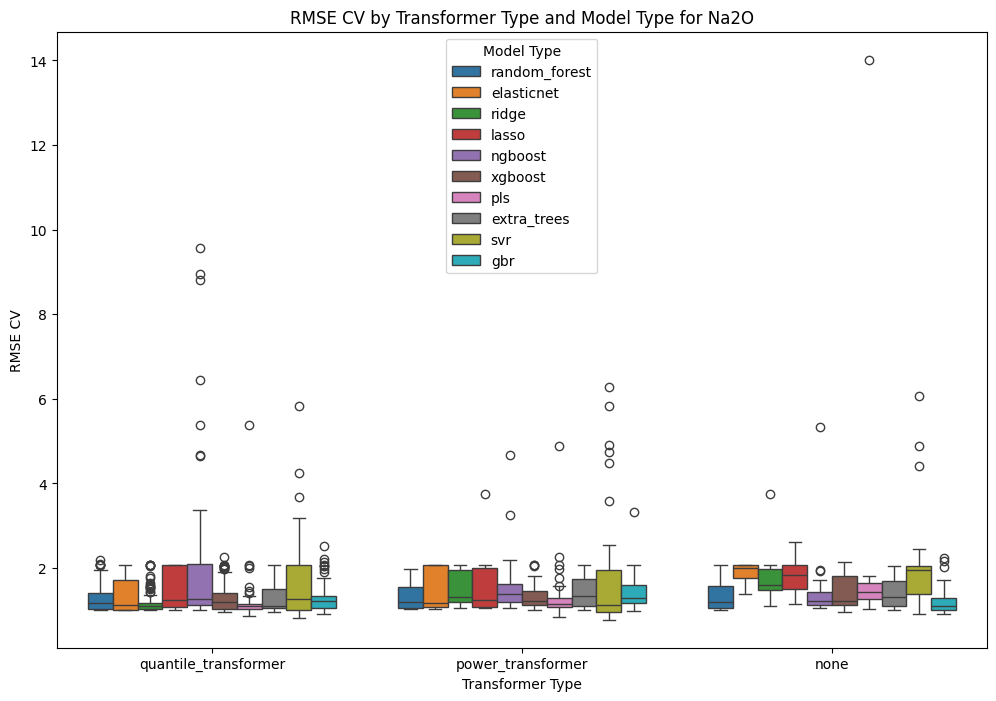

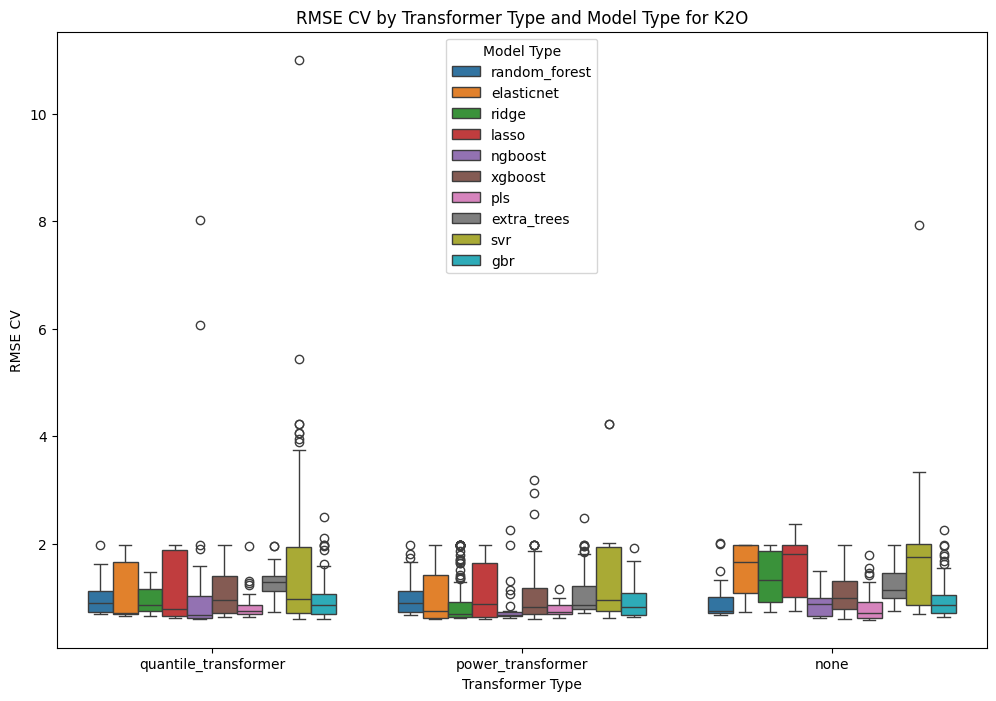

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot for overall RMSE CV by transformer type and model type for each oxide
oxides = filtered_data['params.oxide'].unique()

for oxide in oxides:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data[filtered_data['params.oxide'] == oxide])
    plt.title(f'RMSE CV by Transformer Type and Model Type for {oxide}')
    plt.xlabel('Transformer Type')
    plt.ylabel('RMSE CV')
    plt.legend(title='Model Type')
    plt.show()


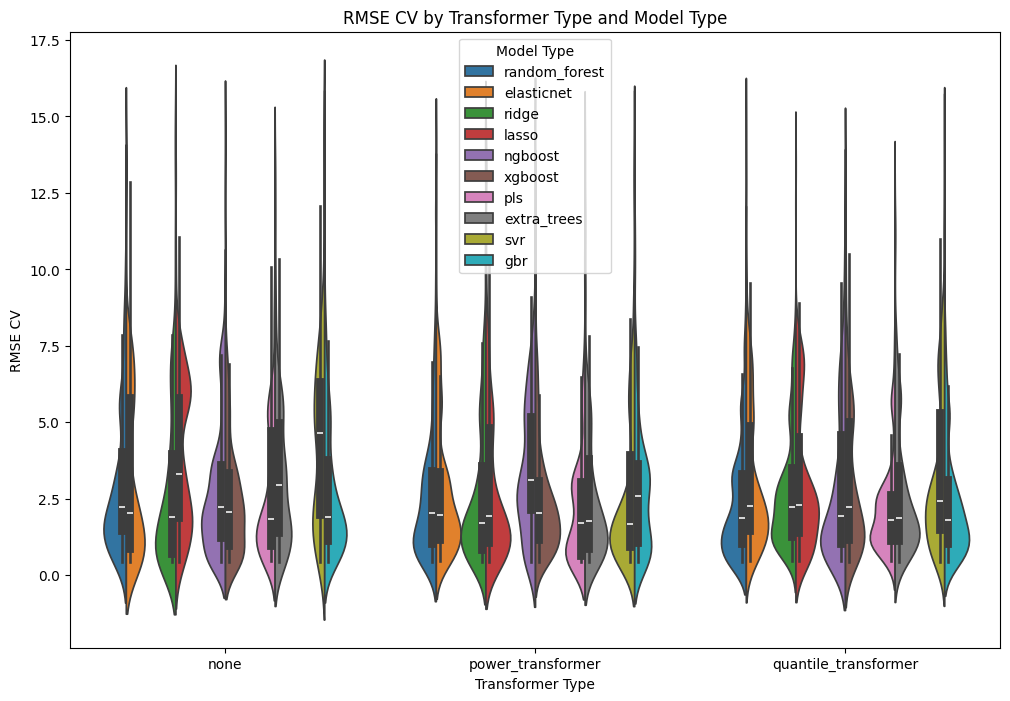

In [49]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.figure(figsize=(12, 8))

# Create a violin plot for overall RMSE CV by transformer type and model type
sns.violinplot(x='params.transformer_type', y='metrics.rmse_cv', hue='params.model_type', data=filtered_data, split=True)

# Title and labels
plt.title('RMSE CV by Transformer Type and Model Type')
plt.xlabel('Transformer Type')
plt.ylabel('RMSE CV')

# Show the plot
plt.legend(title='Model Type')
plt.show()

